In [1]:
import os
import json
import time
from dataclasses import asdict
from pathlib import Path
from typing import Any, Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset I/O
import zarr

# Your module
from spectrum_monitor import (
    WelchConfig, SpectrumModelTrainer, SpectrumMonitor, ModelPack
)

DATASET_PATH = "fm_dataset_200k.zarr"

# Repro
GLOBAL_SEED = 123
rng = np.random.default_rng(GLOBAL_SEED)

# A few practical toggles
USE_KERNEL_FIT = True          # fit kernel hyperparams by MLL on training
TRAIN_MAX_SNAPSHOTS = None     # set e.g. 200 to speed up training if needed
VAL_MAX_SNAPSHOTS = None
TEST_MAX_SNAPSHOTS = None

print("Ready.")


Ready.


In [2]:
def view_to_complex(v: np.ndarray, dtype=np.complex64) -> np.ndarray:
    v = np.asarray(v)
    assert v.shape[-1] == 2
    if dtype == np.complex64:
        return v.astype(np.float32).reshape(v.shape[:-1] + (2,)).view(np.complex64).reshape(v.shape[:-1])
    if dtype == np.complex128:
        return v.astype(np.float64).reshape(v.shape[:-1] + (2,)).view(np.complex128).reshape(v.shape[:-1])
    raise ValueError("dtype must be complex64 or complex128.")


class ZarrDataset:
    def __init__(self, path: str):
        self.path = Path(path)
        self.root = zarr.open_group(str(self.path), mode="r")
        self.N = int(self.root["iq_reim"].shape[0])
        self.num_samples = int(self.root["iq_reim"].shape[1])
        self.M = int(self.root["f_hz"].shape[1])

        self.emitters = [json.loads(line) for line in (self.path / "emitters.jsonl").read_text(encoding="utf-8").splitlines() if line.strip()]
        self.scenarios = [json.loads(line) for line in (self.path / "scenario.jsonl").read_text(encoding="utf-8").splitlines() if line.strip()]
        self.stations = [json.loads(line) for line in (self.path / "stations.jsonl").read_text(encoding="utf-8").splitlines() if line.strip()]

        assert len(self.emitters) == self.N
        assert len(self.scenarios) == self.N
        assert len(self.stations) == self.N

    def __len__(self):
        return self.N

    def get(self, i: int) -> Dict[str, Any]:
        iq = view_to_complex(self.root["iq_reim"][i], dtype=np.complex64)
        return dict(
            iq=iq,
            fs=float(self.root["fs"][i]),
            fc=float(self.root["fc"][i]),
            f_hz=np.asarray(self.root["f_hz"][i]),
            psd_ref=np.asarray(self.root["psd_ref"][i]),
            emitters=self.emitters[i],
            stations=self.stations[i],
            scenario=self.scenarios[i],
        )


ds = ZarrDataset(DATASET_PATH)
print("Loaded dataset:", DATASET_PATH)
print("N:", len(ds), "num_samples:", ds.num_samples, "M(ref grid):", ds.M)
print("Example station count:", len(ds.get(0)["stations"]), "example emitter count:", len(ds.get(0)["emitters"]))


Loaded dataset: fm_dataset_200k.zarr
N: 500 num_samples: 200000 M(ref grid): 8192
Example station count: 16 example emitter count: 102


In [3]:
def make_splits(ds: ZarrDataset, seed: int = 123, train_frac=0.7, val_frac=0.15):
    rng = np.random.default_rng(seed)
    N = len(ds)

    counts = np.array([len(ds.get(i)["stations"]) for i in range(N)])
    # bin station counts for stratification
    bins = np.quantile(counts, [0, 0.25, 0.5, 0.75, 1.0]).astype(int)
    bins = np.unique(bins)
    if len(bins) < 3:  # fallback
        bins = np.array([counts.min(), np.median(counts), counts.max()+1])

    groups = []
    for i in range(len(bins)-1):
        lo, hi = bins[i], bins[i+1]
        idx = np.where((counts >= lo) & (counts <= hi))[0]
        groups.append(idx)

    train_idx, val_idx, test_idx = [], [], []
    for g in groups:
        g = g.copy()
        rng.shuffle(g)
        n = len(g)
        n_train = int(round(train_frac * n))
        n_val = int(round(val_frac * n))
        train_idx.extend(g[:n_train].tolist())
        val_idx.extend(g[n_train:n_train+n_val].tolist())
        test_idx.extend(g[n_train+n_val:].tolist())

    rng.shuffle(train_idx); rng.shuffle(val_idx); rng.shuffle(test_idx)
    return np.array(train_idx), np.array(val_idx), np.array(test_idx)

train_idx, val_idx, test_idx = make_splits(ds, seed=GLOBAL_SEED)
print("Split sizes:", len(train_idx), len(val_idx), len(test_idx))
print("Avg station count train/val/test:",
      np.mean([len(ds.get(i)["stations"]) for i in train_idx]),
      np.mean([len(ds.get(i)["stations"]) for i in val_idx]),
      np.mean([len(ds.get(i)["stations"]) for i in test_idx]))


Split sizes: 404 87 85
Avg station count train/val/test: 16.43069306930693 16.229885057471265 16.376470588235293


In [4]:
# Welch PSD configs you want to compare (resolution axis)
PSD_CONFIGS = [
    dict(name="welch_2048", nperseg=2048, noverlap=1024, window="hann"),
    dict(name="welch_4096", nperseg=4096, noverlap=2048, window="hann"),
    dict(name="welch_8192", nperseg=8192, noverlap=4096, window="hann"),
]

# KL rank axis
R_LIST = [8, 12, 16, 24, 32, 64]

# Your snapshots: 200k samples over 20 MHz => dt = N / Fs
example = ds.get(0)
FS = example["fs"]
FC = example["fc"]
DT_ACQ = ds.num_samples / FS
print("FS:", FS, "FC:", FC, "dt_acq_s:", DT_ACQ)


FS: 20000000.0 FC: 98000000.0 dt_acq_s: 0.01


In [5]:
def greedy_match_by_center(
    true_centers_hz: np.ndarray,
    pred_centers_hz: np.ndarray,
    max_abs_err_hz: float
) -> List[Tuple[int, int, float]]:
    """
    Returns list of (i_true, i_pred, abs_error_hz) matches (greedy closest).
    """
    true_centers_hz = np.asarray(true_centers_hz, dtype=float)
    pred_centers_hz = np.asarray(pred_centers_hz, dtype=float)

    if true_centers_hz.size == 0 or pred_centers_hz.size == 0:
        return []

    # Pairwise abs diffs
    D = np.abs(true_centers_hz[:, None] - pred_centers_hz[None, :])

    # Candidate pairs within tolerance
    pairs = [(i, j, D[i, j]) for i in range(D.shape[0]) for j in range(D.shape[1]) if D[i, j] <= max_abs_err_hz]
    pairs.sort(key=lambda x: x[2])  # closest first

    used_true = set()
    used_pred = set()
    out = []
    for i, j, d in pairs:
        if i in used_true or j in used_pred:
            continue
        used_true.add(i)
        used_pred.add(j)
        out.append((i, j, float(d)))
    return out


def extract_pred_centers_and_bws(pred_emitters: List[Dict[str, float]], center_key="f_centroid_hz"):
    if len(pred_emitters) == 0:
        return np.array([]), np.array([]), np.array([])
    centers = np.array([e[center_key] for e in pred_emitters], dtype=float)
    bws = np.array([e["bw_hz"] for e in pred_emitters], dtype=float)
    peaks = np.array([e["peak_psd"] for e in pred_emitters], dtype=float)
    return centers, bws, peaks


In [6]:
def compute_station_metrics(
    stations: List[Dict[str, float]],
    pred_emitters: List[Dict[str, float]],
    match_tol_hz: float = 120_000.0,
) -> Dict[str, float]:
    """
    Metrics used for tuning (stations only).
    """
    true_f = np.array([s["f_center_hz"] for s in stations], dtype=float)
    true_bw = np.array([s["bw_carson_hz"] for s in stations], dtype=float)

    pred_f, pred_bw, _ = extract_pred_centers_and_bws(pred_emitters, center_key="f_centroid_hz")

    matches = greedy_match_by_center(true_f, pred_f, max_abs_err_hz=match_tol_hz)
    tp = len(matches)
    fp = max(0, len(pred_f) - tp)
    fn = max(0, len(true_f) - tp)

    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1   = (2*prec*rec)/(prec+rec) if (prec+rec) > 0 else 0.0

    if tp > 0:
        f_err = np.array([matches[k][2] for k in range(tp)], dtype=float)  # abs center err
        bw_err = np.array([abs(true_bw[i] - pred_bw[j]) for (i, j, _) in matches], dtype=float)

        mae_f = float(np.mean(f_err))
        mae_bw = float(np.mean(bw_err))
        med_f = float(np.median(f_err))
        med_bw = float(np.median(bw_err))
    else:
        mae_f = mae_bw = med_f = med_bw = np.nan

    return dict(
        n_true=len(true_f),
        n_pred=len(pred_f),
        tp=tp, fp=fp, fn=fn,
        precision=prec, recall=rec, f1=f1,
        mae_center_hz=mae_f, med_center_hz=med_f,
        mae_bw_hz=mae_bw, med_bw_hz=med_bw,
    )


def compute_emitter_tracking_metrics(
    emitters_ref: List[Dict[str, float]],
    pred_emitters: List[Dict[str, float]],
    match_tol_hz: float = 80_000.0,
) -> Dict[str, float]:
    """
    Tracking-only metrics (NOT used for tuning).
    emitters_ref provide f_center_ref_hz (peak), B_ref_hz (-3dB width), P_peak_ref.
    """
    true_f = np.array([e["f_center_ref_hz"] for e in emitters_ref], dtype=float)
    true_bw = np.array([e["B_ref_hz"] for e in emitters_ref], dtype=float)
    true_pk = np.array([e["P_peak_ref"] for e in emitters_ref], dtype=float)

    pred_f = np.array([e["f_peak_hz"] for e in pred_emitters], dtype=float) if pred_emitters else np.array([])
    pred_bw = np.array([e["bw_hz"] for e in pred_emitters], dtype=float) if pred_emitters else np.array([])
    pred_pk = np.array([e["peak_psd"] for e in pred_emitters], dtype=float) if pred_emitters else np.array([])

    matches = greedy_match_by_center(true_f, pred_f, max_abs_err_hz=match_tol_hz)

    tp = len(matches)
    fp = max(0, len(pred_f) - tp)
    fn = max(0, len(true_f) - tp)

    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1   = (2*prec*rec)/(prec+rec) if (prec+rec) > 0 else 0.0

    if tp > 0:
        f_err = np.array([abs(true_f[i]-pred_f[j]) for (i,j,_) in matches], dtype=float)
        bw_err = np.array([abs(true_bw[i]-pred_bw[j]) for (i,j,_) in matches], dtype=float)
        # peak power compare in dB for stability
        pk_db_err = np.array([abs(10*np.log10(true_pk[i]+1e-30) - 10*np.log10(pred_pk[j]+1e-30)) for (i,j,_) in matches], dtype=float)

        return dict(
            n_true=len(true_f), n_pred=len(pred_f),
            tp=tp, fp=fp, fn=fn,
            precision=prec, recall=rec, f1=f1,
            mae_center_hz=float(np.mean(f_err)),
            mae_bw_hz=float(np.mean(bw_err)),
            mae_peak_db=float(np.mean(pk_db_err)),
        )
    else:
        return dict(
            n_true=len(true_f), n_pred=len(pred_f),
            tp=tp, fp=fp, fn=fn,
            precision=prec, recall=rec, f1=f1,
            mae_center_hz=np.nan,
            mae_bw_hz=np.nan,
            mae_peak_db=np.nan,
        )


In [7]:
def take_subset(idx: np.ndarray, max_n: Optional[int], seed: int):
    if max_n is None or len(idx) <= max_n:
        return idx
    rr = np.random.default_rng(seed)
    pick = rr.choice(idx, size=max_n, replace=False)
    return np.array(pick)

train_idx_s = take_subset(train_idx, TRAIN_MAX_SNAPSHOTS, seed=GLOBAL_SEED+1)
val_idx_s   = take_subset(val_idx,   VAL_MAX_SNAPSHOTS,   seed=GLOBAL_SEED+2)
test_idx_s  = take_subset(test_idx,  TEST_MAX_SNAPSHOTS,  seed=GLOBAL_SEED+3)

train_samples = [ds.get(i) for i in train_idx_s]
val_samples   = [ds.get(i) for i in val_idx_s]
test_samples  = [ds.get(i) for i in test_idx_s]

print("Using train/val/test:", len(train_samples), len(val_samples), len(test_samples))


Using train/val/test: 404 87 85


In [8]:
# Key tunables
C_EPS_GRID = [0.6, 0.8, 1.0, 1.25, 1.6, 2.0]   # sigma_eps scale
PI0_GRID   = [0.90, 0.95, 0.98]
PFA_GRID   = [3e-4, 1e-3, 3e-3, 1e-2]
QUIET_FRAC_GRID = [0.15, 0.25, 0.35]

# Matching tolerances
STATION_MATCH_TOL_HZ = 120_000.0  # station center tolerance
EMITTER_MATCH_TOL_HZ = 80_000.0   # ref-peak tolerance

In [10]:
def train_modelpack_for_config(train_samples, psd_cfg: Dict[str, Any], R: int, seed: int = 0) -> ModelPack:
    trainer = SpectrumModelTrainer(random_seed=seed)

    # WelchConfig for the module uses dt_acq_s (not fs directly)
    welch_cfg = WelchConfig(
        fc_hz=float(FC),
        fs_hz=float(FS),
        nperseg=int(psd_cfg["nperseg"]),
        noverlap=int(psd_cfg["noverlap"]),
        window=str(psd_cfg["window"]),
        detrend=False,
        average="mean",
    )

    xs = [s["iq"] for s in train_samples]

    modelpack = trainer.train_from_iq(
        xs=xs,
        welch_cfg=welch_cfg,
        R=int(R),
        quiet_frac=0.25,
        fit_kernel=USE_KERNEL_FIT,
        fit_indices=(0, 25, 50, 75),
        n_restarts=2,
        version=f"mp_{psd_cfg['name']}_R{R}",
    )
    return modelpack

print("Defined training function.")


Defined training function.


In [11]:
def station_tuning_score(m: Dict[str, float]) -> float:
    """
    Single scalar for tuning. You can change weights.
    Goal: prioritize correct detection, but penalize large center/BW errors.
    """
    f1 = m["f1"]

    # If no matches, strongly penalize
    if not np.isfinite(m["mae_center_hz"]) or not np.isfinite(m["mae_bw_hz"]):
        return -1e9

    # Normalize errors to "reasonable FM scales"
    # center: 0..100 kHz, bw: 0..200 kHz-ish
    e_center = m["mae_center_hz"] / 50_000.0
    e_bw     = m["mae_bw_hz"] / 120_000.0

    # Weighted score
    return float(f1 - 0.25 * e_center - 0.15 * e_bw)


def tune_on_val_stations(modelpack: ModelPack, val_samples: List[Dict[str, Any]]) -> Dict[str, Any]:
    mon = SpectrumMonitor(modelpack)

    base_sigma = float(modelpack.kernel_params.sigma_eps)

    best = None

    for quiet_frac in QUIET_FRAC_GRID:
        for c_eps in C_EPS_GRID:
            sig = base_sigma * float(c_eps)
            for pi0 in PI0_GRID:
                for pfa in PFA_GRID:
                    # aggregate across val
                    metrics_list = []
                    for s in val_samples:
                        out = mon.infer_snapshot(
                            s["iq"],
                            quiet_frac=float(quiet_frac),
                            pi0=float(pi0),
                            p_fa_bin=float(pfa),
                            sigma_eps=float(sig),
                        )
                        m = compute_station_metrics(s["stations"], out.emitters, match_tol_hz=STATION_MATCH_TOL_HZ)
                        metrics_list.append(m)

                    # macro-average across snapshots
                    dfm = pd.DataFrame(metrics_list)
                    agg = {
                        "f1": float(dfm["f1"].mean()),
                        "precision": float(dfm["precision"].mean()),
                        "recall": float(dfm["recall"].mean()),
                        "mae_center_hz": float(dfm["mae_center_hz"].mean(skipna=True)),
                        "mae_bw_hz": float(dfm["mae_bw_hz"].mean(skipna=True)),
                        "avg_n_true": float(dfm["n_true"].mean()),
                        "avg_n_pred": float(dfm["n_pred"].mean()),
                    }
                    score = station_tuning_score({**agg, **{"mae_center_hz": agg["mae_center_hz"], "mae_bw_hz": agg["mae_bw_hz"]}})

                    cand = dict(
                        params=dict(
                            quiet_frac=float(quiet_frac),
                            c_eps=float(c_eps),
                            sigma_eps=float(sig),
                            pi0=float(pi0),
                            p_fa_bin=float(pfa),
                        ),
                        val_station_metrics=agg,
                        score=float(score),
                    )

                    if best is None or cand["score"] > best["score"]:
                        best = cand

    return best

print("Defined tuning routine.")


Defined tuning routine.


In [22]:
all_rows = []

for psd_cfg in PSD_CONFIGS:
    for R in R_LIST:
        print(f"\n=== Training {psd_cfg['name']} with R={R} ===")
        t0 = time.perf_counter()

        mp = train_modelpack_for_config(train_samples, psd_cfg, R, seed=GLOBAL_SEED)
        train_time = time.perf_counter() - t0

        print("Training done. Base sigma_eps:", float(mp.kernel_params.sigma_eps), "train_time_s:", train_time)

        print("Tuning on VAL (stations only)...")
        t1 = time.perf_counter()
        best = tune_on_val_stations(mp, val_samples)
        tune_time = time.perf_counter() - t1

        print("Best score:", best["score"])
        print("Best params:", best["params"])
        print("VAL station metrics:", best["val_station_metrics"])

        row = dict(
            psd_name=psd_cfg["name"],
            nperseg=int(psd_cfg["nperseg"]),
            noverlap=int(psd_cfg["noverlap"]),
            window=str(psd_cfg["window"]),
            R=int(R),
            train_time_s=float(train_time),
            tune_time_s=float(tune_time),
            **{f"best_{k}": v for k, v in best["params"].items()},
            **{f"val_station_{k}": v for k, v in best["val_station_metrics"].items()},
            val_score=float(best["score"]),
            modelpack=mp,  # keep in memory for now
        )
        all_rows.append(row)

results_df = pd.DataFrame(all_rows)
results_df.sort_values(["psd_name", "R"], inplace=True)
results_df


=== Training welch_2048 with R=8 ===
Training done. Base sigma_eps: 4.574671672777188e-16 train_time_s: 197.4277790999986
Tuning on VAL (stations only)...
Best score: -10.683704273664311
Best params: {'quiet_frac': 0.35, 'c_eps': 0.8, 'sigma_eps': 3.6597373382217503e-16, 'pi0': 0.98, 'p_fa_bin': 0.01}
VAL station metrics: {'f1': 0.05211881102631087, 'precision': 0.20498084291187738, 'recall': 0.03159015651372414, 'mae_center_hz': 57819.365234263845, 'mae_bw_hz': 8357381.006815443, 'avg_n_true': 16.229885057471265, 'avg_n_pred': 2.057471264367816}

=== Training welch_2048 with R=12 ===
Training done. Base sigma_eps: 4.574671672777188e-16 train_time_s: 79.60588389999975
Tuning on VAL (stations only)...
Best score: -7.312675455291548
Best params: {'quiet_frac': 0.35, 'c_eps': 1.0, 'sigma_eps': 4.574671672777188e-16, 'pi0': 0.98, 'p_fa_bin': 0.0003}
VAL station metrics: {'f1': 0.084992424949469, 'precision': 0.24674329501915707, 'recall': 0.05703042410027153, 'mae_center_hz': 59616.785087

KeyboardInterrupt: 

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment


def match_emitters_to_stations(
    preds,
    truths,
    max_freq_err_hz=200_000,   # 200 kHz tolerance
    miss_cost=300_000,
):
    """
    Match predicted emitters to true stations using nearest frequency.
    Returns list of (i_pred, i_true).
    """
    if len(preds) == 0 or len(truths) == 0:
        return []

    cost = np.full((len(preds), len(truths)), miss_cost, dtype=float)

    for i, p in enumerate(preds):
        for j, t in enumerate(truths):
            df = abs(p["f_peak_hz"] - t["f_center_hz"])
            if df <= max_freq_err_hz:
                cost[i, j] = df

    row_ind, col_ind = linear_sum_assignment(cost)

    matches = []
    for i, j in zip(row_ind, col_ind):
        if cost[i, j] < miss_cost:
            matches.append((i, j))

    return matches


def eval_on_val_stations(
    modelpack,
    val_samples,
    params,
):
    """
    Evaluate station detection + parameter estimation accuracy.
    """

    mon = SpectrumMonitor(modelpack)

    n_tp = n_fp = n_fn = 0
    err_fc = []
    err_bw = []

    n_true_all = []
    n_pred_all = []

    for s in val_samples:
        res = mon.infer_snapshot(
            s["iq"],
            quiet_frac=params["quiet_frac"],
            p_fa_bin=params["p_fa_bin"],
            pi0=params["pi0"],
            sigma_eps=params["sigma_eps"],
        )

        preds = res.emitters
        truths = s["stations"]

        matches = match_emitters_to_stations(preds, truths)

        n_tp += len(matches)
        n_fp += len(preds) - len(matches)
        n_fn += len(truths) - len(matches)

        for i_p, i_t in matches:
            p = preds[i_p]
            t = truths[i_t]

            err_fc.append(abs(p["f_peak_hz"] - t["f_center_hz"]))
            err_bw.append(abs(p["bw_hz"] - t["bw_carson_hz"]))

        n_true_all.append(len(truths))
        n_pred_all.append(len(preds))

    precision = n_tp / max(n_tp + n_fp, 1)
    recall = n_tp / max(n_tp + n_fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-12)

    return dict(
        f1=float(f1),
        precision=float(precision),
        recall=float(recall),
        mae_center_hz=float(np.mean(err_fc)) if err_fc else np.nan,
        mae_bw_hz=float(np.mean(err_bw)) if err_bw else np.nan,
        avg_n_true=float(np.mean(n_true_all)),
        avg_n_pred=float(np.mean(n_pred_all)),
    )


In [36]:
# ============================================================
# Optimized training + tuning (kernel fitted once per grid)
# ============================================================

import time
import json
import numpy as np
from pathlib import Path

# -----------------------------
# Global config
# -----------------------------
GLOBAL_SEED = 123
R_LIST = [8, 12, 16, 24, 32, 64]
R_MAX = max(R_LIST)

PSD_CONFIGS = [
    dict(name="welch_2048", nperseg=2048, noverlap=1024, window="hann"),
    dict(name="welch_4096", nperseg=4096, noverlap=2048, window="hann"),
    dict(name="welch_8192", nperseg=8192, noverlap=4096, window="hann"),
]

DATASET_PATH = "fm_dataset_200k.zarr"
OUT_PATH = Path("tuning_results.json")

# -----------------------------
# Load dataset and split
# -----------------------------
ds = ZarrDataset(DATASET_PATH)
samples = [ds.get(i) for i in range(len(ds))]

rng = np.random.default_rng(GLOBAL_SEED)
rng.shuffle(samples)

N = len(samples)
n_train = int(0.7 * N)
n_val   = int(0.15 * N)

train_samples = samples[:n_train]
val_samples   = samples[n_train:n_train + n_val]
test_samples  = samples[n_train + n_val:]

print(f"Dataset split: train={len(train_samples)}, val={len(val_samples)}, test={len(test_samples)}")

# -----------------------------
# Results container
# -----------------------------
ALL_RESULTS = {}

# ============================================================
# Main loop: PSD grid → train once → truncate R → tune
# ============================================================
for psd_cfg in PSD_CONFIGS:
    print(f"\n==============================")
    print(f"PSD CONFIG: {psd_cfg['name']}")
    print(f"==============================")

    # ---- Train kernel ONCE at R_MAX ----
    t0 = time.perf_counter()

    trainer = SpectrumModelTrainer(random_seed=GLOBAL_SEED)

    welch_cfg = WelchConfig(
        fc_hz=float(FC),
        fs_hz=float(FS),
        nperseg=int(psd_cfg["nperseg"]),
        noverlap=int(psd_cfg["noverlap"]),
        window=str(psd_cfg["window"]),
        detrend=False,
        average="mean",
    )

    # IMPORTANT: kernel fitting does NOT need all training snapshots
    xs_train_kernel = [s["iq"] for s in train_samples[:80]]

    mp_max = trainer.train_from_iq(
        xs=xs_train_kernel,
        welch_cfg=welch_cfg,
        R=R_MAX,
        quiet_frac=0.25,
        fit_kernel=True,
        fit_indices=(0, 10, 20, 40, 60),
        n_restarts=2,
        version=f"mp_{psd_cfg['name']}_Rmax{R_MAX}",
    )

    train_time = time.perf_counter() - t0
    print(f"Kernel trained once at R={R_MAX} in {train_time:.2f} s")
    print("Base sigma_eps:", float(mp_max.kernel_params.sigma_eps))

    ALL_RESULTS[psd_cfg["name"]] = {
        "train_time_s": train_time,
        "kernel_params": vars(mp_max.kernel_params),
        "R_results": {},
    }

    # ---- Loop over R via truncation ----
    for R in R_LIST:
        print(f"\n--- Evaluating R={R} ---")

        mp_R = mp_max.with_truncated_R(R)

        # ---- Tune scalar params on validation (stations only) ----
        t1 = time.perf_counter()
        best = tune_on_val_stations(mp_R, val_samples)
        tune_time = time.perf_counter() - t1

        metrics_val = eval_on_val_stations(
            mp_R,
            val_samples,
            best["params"],
        )

        print("Best score:", best["score"])
        print("Best params:", best["params"])
        print("VAL metrics:", metrics_val)

        ALL_RESULTS[psd_cfg["name"]]["R_results"][R] = dict(
            best_params=best["params"],
            best_score=best["score"],
            val_metrics=metrics_val,
            tune_time_s=tune_time,
        )

# -----------------------------
# Save results to disk
# -----------------------------
OUT_PATH.write_text(json.dumps(ALL_RESULTS, indent=2))
print("\nSaved tuning results to:", OUT_PATH.resolve())

Dataset split: train=350, val=75, test=75

PSD CONFIG: welch_2048
Kernel trained once at R=64 in 125.05 s
Base sigma_eps: 4.503301134800356e-16

--- Evaluating R=8 ---
Best score: -12.07589717705243
Best params: {'quiet_frac': 0.35, 'c_eps': 0.8, 'sigma_eps': 3.6026409078402846e-16, 'pi0': 0.95, 'p_fa_bin': 0.0003}
VAL metrics: {'f1': 0.22097114707952142, 'precision': 1.0, 'recall': 0.12420886075949367, 'mae_center_hz': 4676244.028662421, 'mae_bw_hz': 8094165.396474828, 'avg_n_true': 16.85333333333333, 'avg_n_pred': 2.0933333333333333}

--- Evaluating R=12 ---
Best score: -9.347643673224168
Best params: {'quiet_frac': 0.35, 'c_eps': 1.0, 'sigma_eps': 4.503301134800356e-16, 'pi0': 0.98, 'p_fa_bin': 0.0003}
VAL metrics: {'f1': 0.3065595716198126, 'precision': 0.9956521739130435, 'recall': 0.18117088607594936, 'mae_center_hz': 4397792.712882096, 'mae_bw_hz': 5249185.626396181, 'avg_n_true': 16.85333333333333, 'avg_n_pred': 3.066666666666667}

--- Evaluating R=16 ---
Best score: -6.9968185

In [37]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open("tuning_results.json", "r") as f:
    results = json.load(f)


In [38]:
def extract_curves(results, welch_name):
    R_vals = sorted(int(r) for r in results[welch_name]["R_results"].keys())
    metrics = {}
    for k in ["f1", "precision", "recall", "mae_center_hz", "mae_bw_hz", "avg_n_true", "avg_n_pred"]:
        metrics[k] = [
            results[welch_name]["R_results"][str(R)]["val_metrics"][k]
            for R in R_vals
        ]
    return np.array(R_vals), metrics


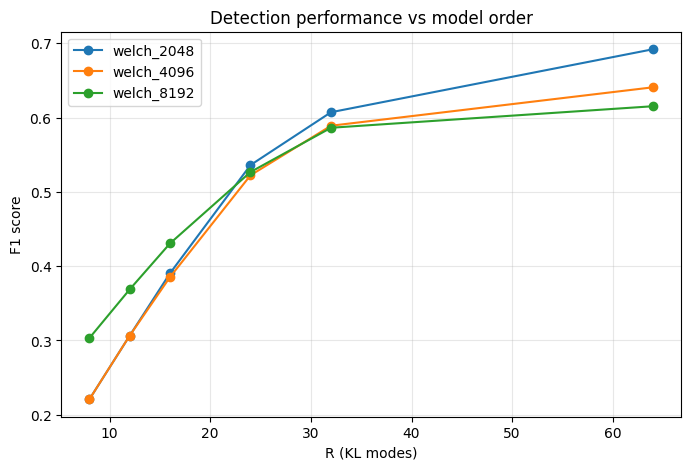

In [39]:
plt.figure(figsize=(8,5))

for welch in results:
    R, m = extract_curves(results, welch)
    plt.plot(R, m["f1"], marker="o", label=welch)

plt.xlabel("R (KL modes)")
plt.ylabel("F1 score")
plt.title("Detection performance vs model order")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


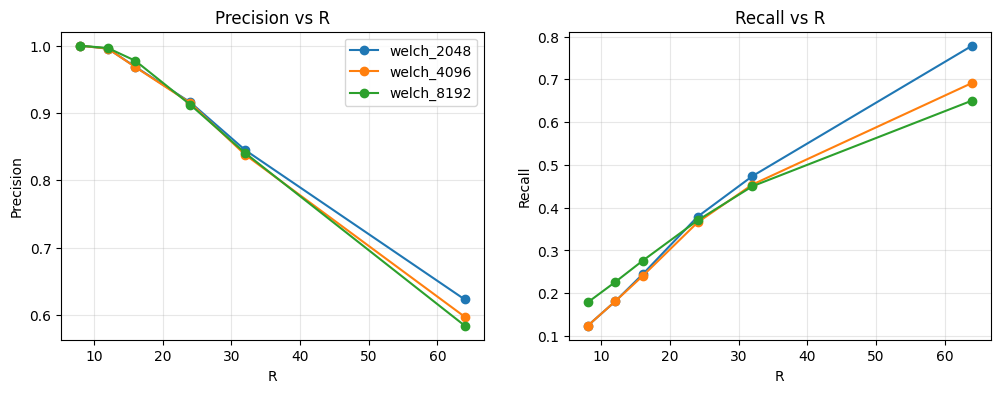

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharex=True)

for welch in results:
    R, m = extract_curves(results, welch)
    axes[0].plot(R, m["precision"], marker="o", label=welch)
    axes[1].plot(R, m["recall"], marker="o", label=welch)

axes[0].set_title("Precision vs R")
axes[1].set_title("Recall vs R")

for ax in axes:
    ax.set_xlabel("R")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Precision")
axes[1].set_ylabel("Recall")
axes[0].legend()
plt.show()


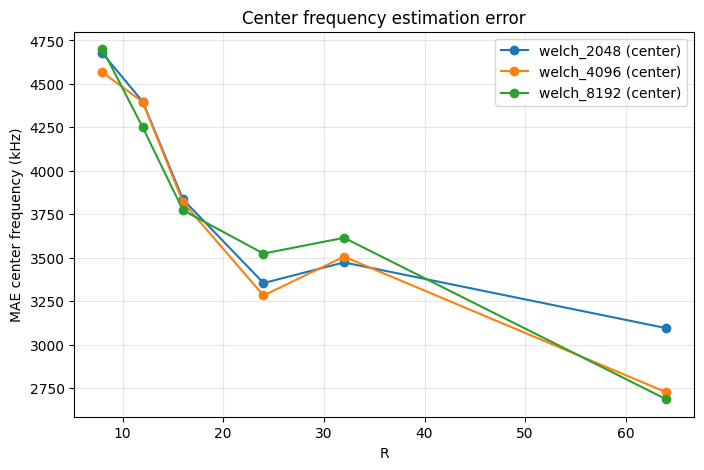

In [41]:
plt.figure(figsize=(8,5))

for welch in results:
    R, m = extract_curves(results, welch)
    plt.plot(R, np.array(m["mae_center_hz"]) / 1e3, marker="o", label=f"{welch} (center)")

plt.xlabel("R")
plt.ylabel("MAE center frequency (kHz)")
plt.title("Center frequency estimation error")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


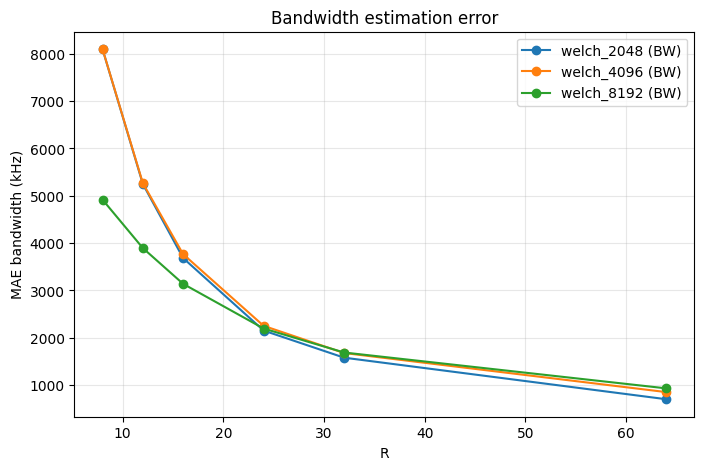

In [42]:
plt.figure(figsize=(8,5))

for welch in results:
    R, m = extract_curves(results, welch)
    plt.plot(R, np.array(m["mae_bw_hz"]) / 1e3, marker="o", label=f"{welch} (BW)")

plt.xlabel("R")
plt.ylabel("MAE bandwidth (kHz)")
plt.title("Bandwidth estimation error")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


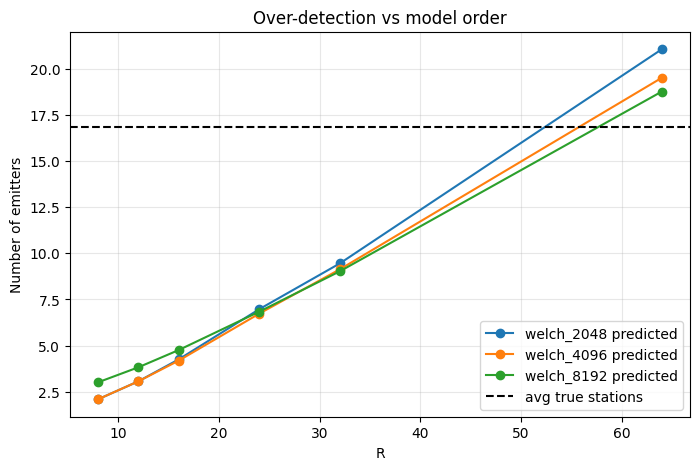

In [43]:
plt.figure(figsize=(8,5))

for welch in results:
    R, m = extract_curves(results, welch)
    plt.plot(R, m["avg_n_pred"], marker="o", label=f"{welch} predicted")

plt.axhline(m["avg_n_true"][0], color="k", linestyle="--", label="avg true stations")

plt.xlabel("R")
plt.ylabel("Number of emitters")
plt.title("Over-detection vs model order")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [9]:
import json
from pathlib import Path

from spectrum_monitor import (
    SpectrumModelTrainer,
    WelchConfig,
    KernelParamsComposite,
    ModelPack,
)

# -----------------------------
# Paths
# -----------------------------
TUNING_JSON = "tuning_results.json"
OUT_DIR = Path("modelpacks_from_tuning")
OUT_DIR.mkdir(exist_ok=True)

# -----------------------------
# Load tuning results
# -----------------------------
with open(TUNING_JSON, "r", encoding="utf-8") as f:
    tuning = json.load(f)

trainer = SpectrumModelTrainer(random_seed=0)

# -----------------------------
# Welch configs used in tuning
# -----------------------------
PSD_CFGS = {
    "welch_2048": dict(nperseg=2048, noverlap=1024, window="hann"),
    "welch_4096": dict(nperseg=4096, noverlap=2048, window="hann"),
    "welch_8192": dict(nperseg=8192, noverlap=4096, window="hann"),
}

FS = 20_000_000
FC = 98_000_000

saved = []

for welch_name, blob in tuning.items():
    if welch_name not in PSD_CFGS:
        continue

    cfg = PSD_CFGS[welch_name]

    welch_cfg = WelchConfig(
        fc_hz=FC,
        fs_hz=FS,              # IMPORTANT: use fs_hz variant
        nperseg=cfg["nperseg"],
        noverlap=cfg["noverlap"],
        window=cfg["window"],
        detrend=False,
        average="mean",
    )

    kp0 = blob["kernel_params"]
    kernel_params = KernelParamsComposite(
        ell_short_hz=kp0["ell_short_hz"],
        ell_long_hz=kp0["ell_long_hz"],
        a1=kp0["a1"],
        a2=kp0["a2"],
        sigma_eps=kp0["sigma_eps"],
    )

    for R_str, rr in blob["R_results"].items():
        R = int(R_str)

        # use tuned sigma_eps if available
        best = rr.get("best_params", {})
        if "sigma_eps" in best:
            kernel_params_use = KernelParamsComposite(
                ell_short_hz=kernel_params.ell_short_hz,
                ell_long_hz=kernel_params.ell_long_hz,
                a1=kernel_params.a1,
                a2=kernel_params.a2,
                sigma_eps=best["sigma_eps"],
            )
        else:
            kernel_params_use = kernel_params

        version = f"mp_{welch_name}_R{R}"

        mp = trainer.build_modelpack_from_kernel(
            welch_cfg=welch_cfg,
            kernel_params=kernel_params_use,
            R=R,
        )

        # attach tuned detection params
        mp.p_fa_bin = best.get("p_fa_bin", mp.p_fa_bin)
        mp.pi0 = best.get("pi0", mp.pi0)

        out = OUT_DIR / f"{version}.npz"
        mp.save(out)
        saved.append(out)

print(f"Saved {len(saved)} ModelPacks")
print(saved[:3])


Saved 18 ModelPacks
[WindowsPath('modelpacks_from_tuning/mp_welch_2048_R8.npz'), WindowsPath('modelpacks_from_tuning/mp_welch_2048_R12.npz'), WindowsPath('modelpacks_from_tuning/mp_welch_2048_R16.npz')]


Welch configs found: ['welch_2048', 'welch_4096', 'welch_8192']
Plotting sample indices: [317, 255, 423]


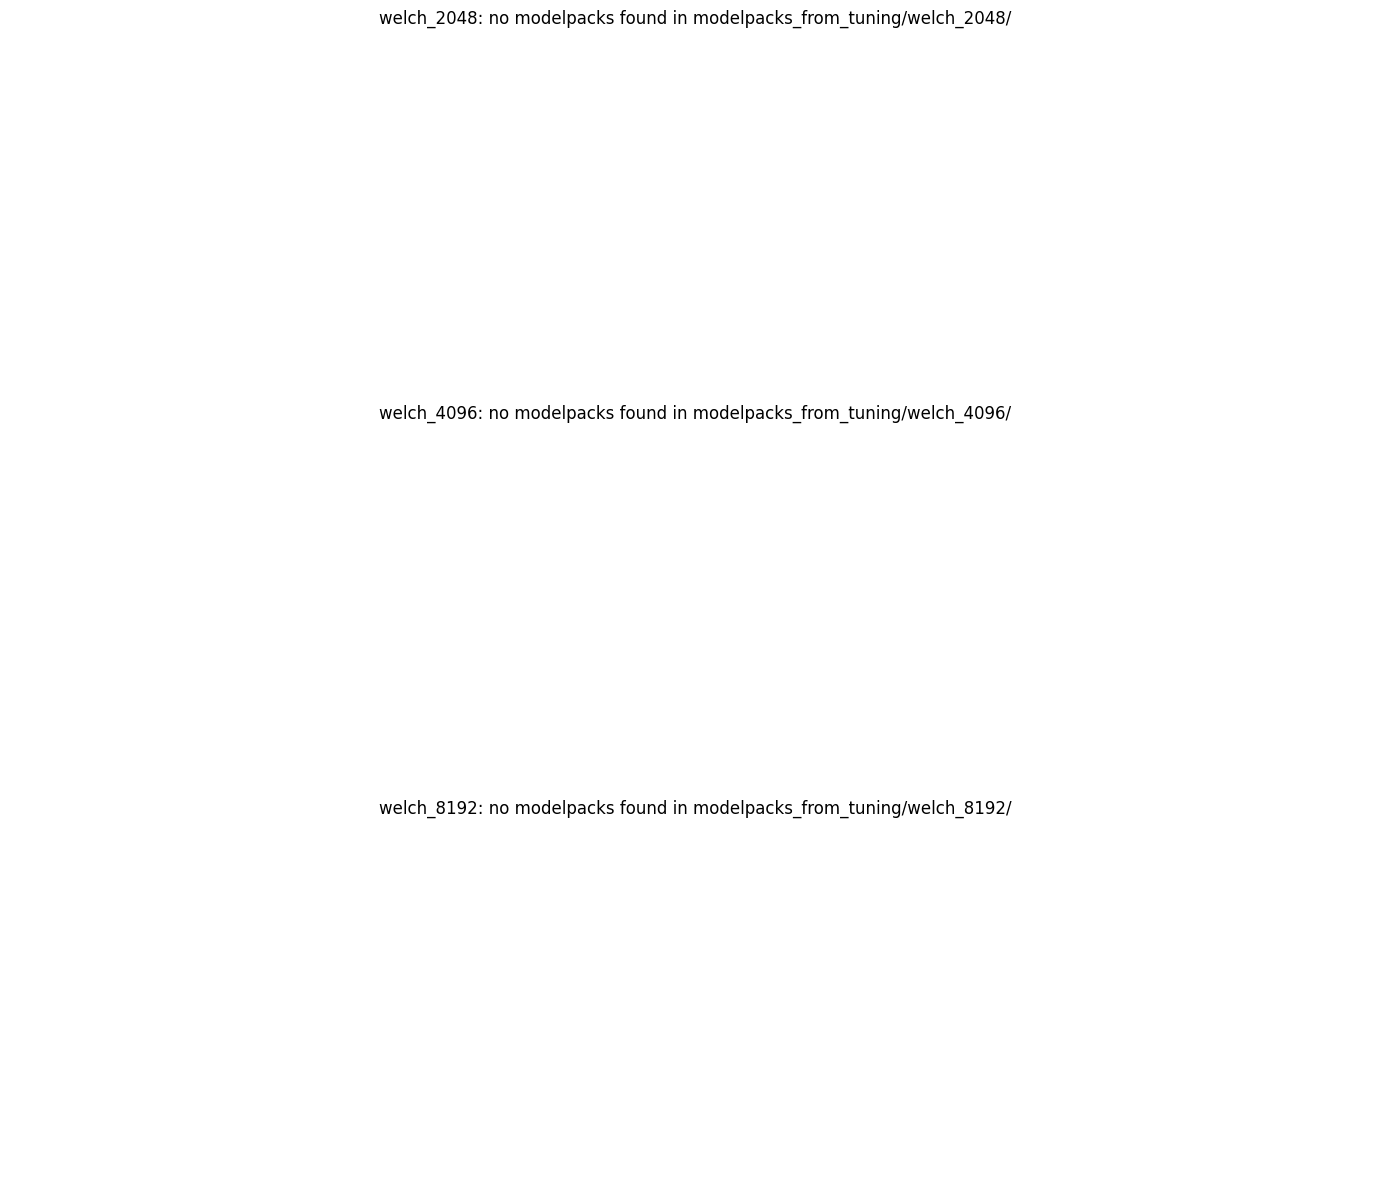

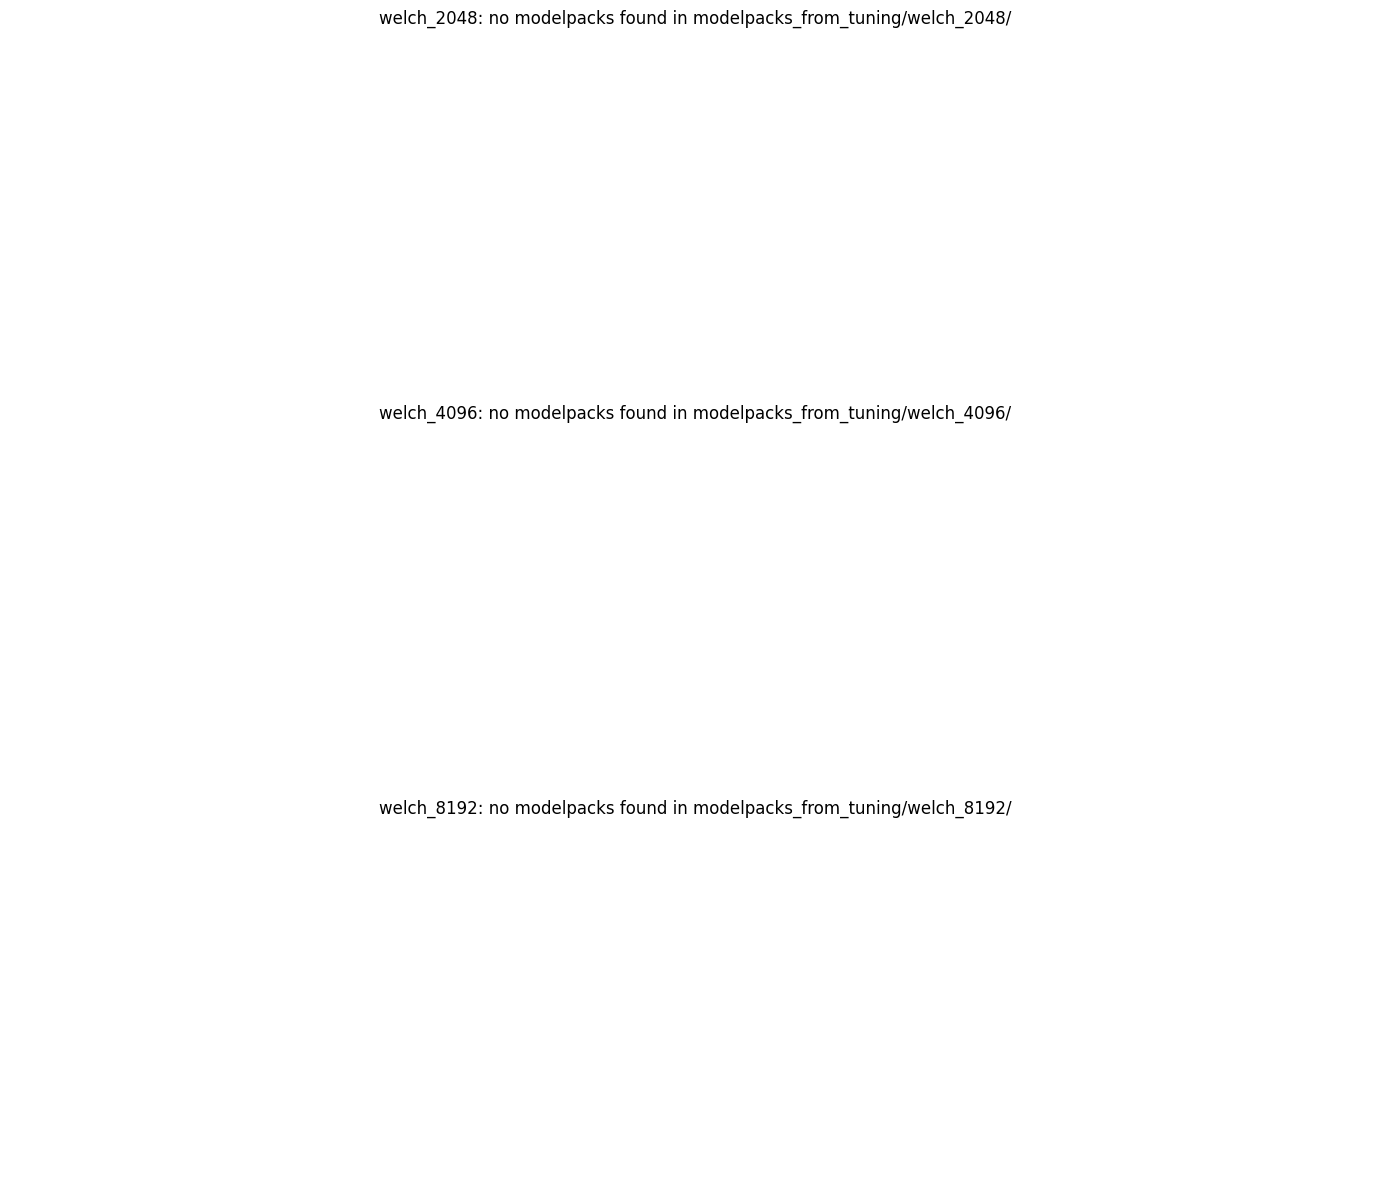

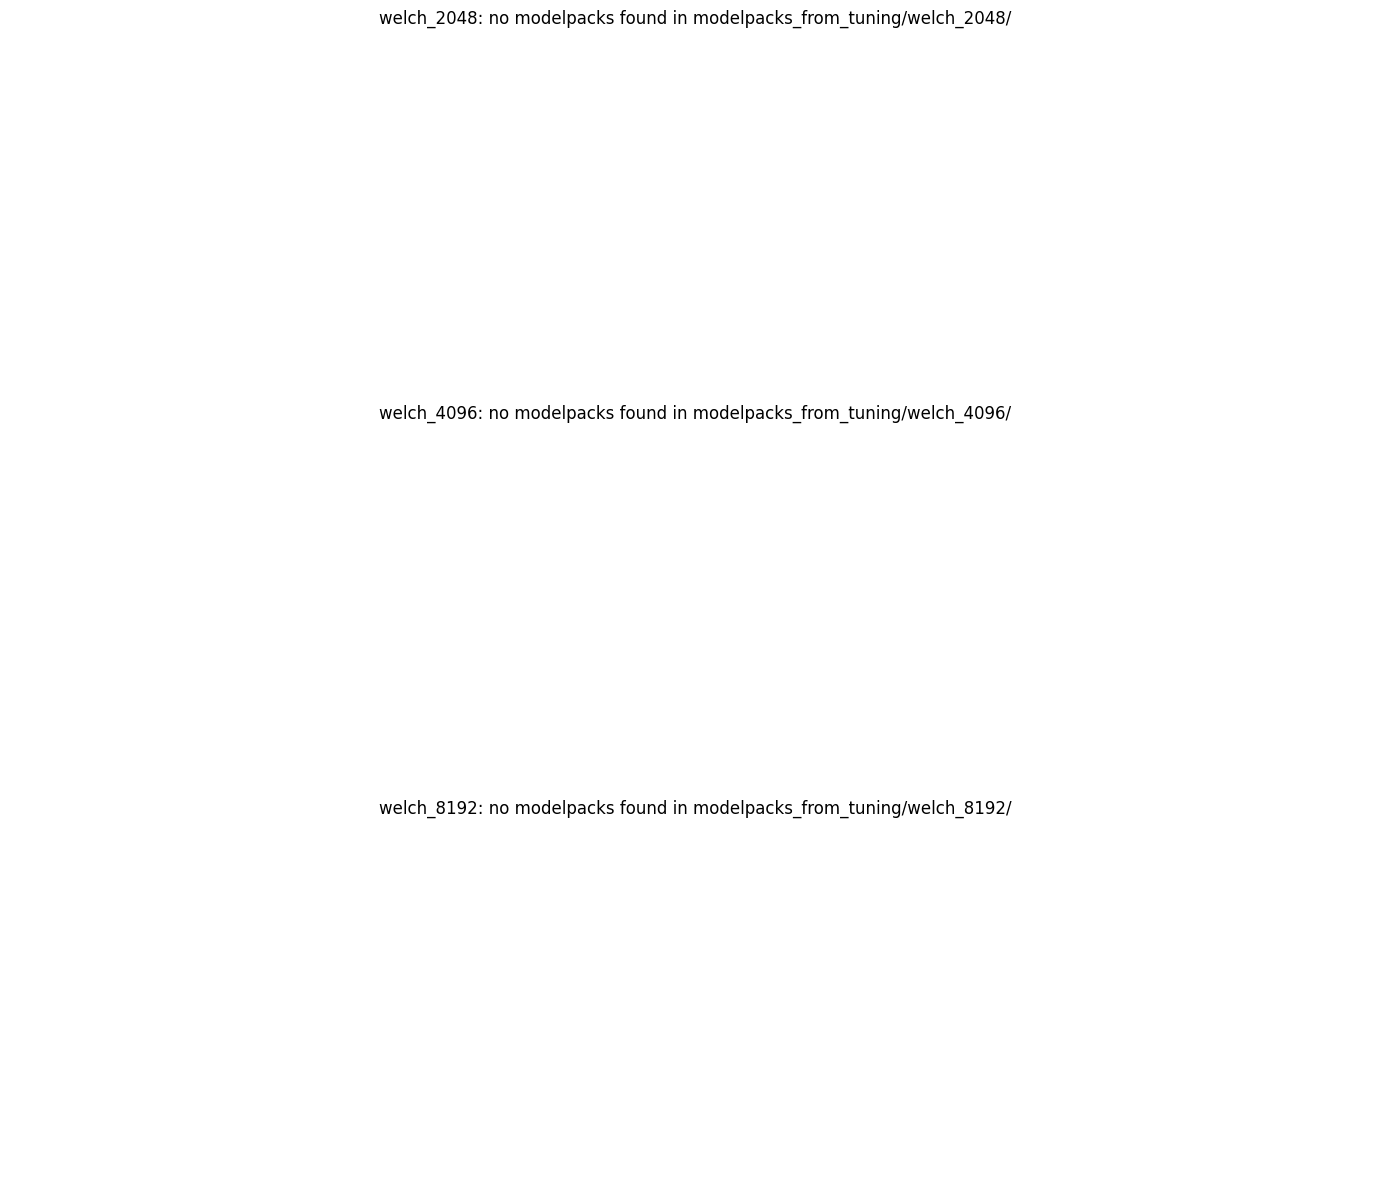

In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt
import zarr
from pathlib import Path

# ----------------------------
# 0) EDIT THESE PATHS
# ----------------------------
DATASET_PATH = "fm_dataset_200k.zarr"
TUNING_RESULTS_JSON = "tuning_results.json"

# Point this to where you saved modelpacks during tuning.
# Expected file name pattern below: modelpacks/{welch_name}/R{R}.npz
MODELPACK_ROOT = Path("modelpacks_from_tuning")

# Choose which R curves to overlay (use whatever you trained)
R_TO_PLOT = [8, 16, 24, 32, 64]

# How many random samples to plot
K_SAMPLES = 3
SEED = 0

# Frequency display window (MHz); full 20 MHz band around 98 MHz is typically 88–108 MHz if your grid matches
XLIM_MHZ = (88, 108)

# ----------------------------
# 1) Load dataset helper (minimal)
# ----------------------------
def view_to_complex(v: np.ndarray, dtype=np.complex64) -> np.ndarray:
    v = np.asarray(v)
    if v.shape[-1] != 2:
        raise ValueError("Last dim must be 2 (real, imag).")
    if dtype == np.complex64:
        return v.astype(np.float32).reshape(v.shape[:-1] + (2,)).view(np.complex64).reshape(v.shape[:-1])
    raise ValueError("Only complex64 supported here.")

def load_jsonl(path: Path):
    return [json.loads(line) for line in path.read_text(encoding="utf-8").splitlines() if line.strip()]

root = zarr.open_group(DATASET_PATH, mode="r")
N = int(root["iq_reim"].shape[0])

emitters_json = load_jsonl(Path(DATASET_PATH) / "emitters.jsonl")
stations_json  = load_jsonl(Path(DATASET_PATH) / "stations.jsonl")
scenarios_json = load_jsonl(Path(DATASET_PATH) / "scenario.jsonl")

def get_sample(i: int):
    iq = view_to_complex(root["iq_reim"][i], dtype=np.complex64)
    return dict(
        iq=iq,
        fs=float(root["fs"][i]),
        fc=float(root["fc"][i]),
        stations=stations_json[i],
        emitters=emitters_json[i],
        scenario=scenarios_json[i],
    )

# ----------------------------
# 2) Load tuning results to discover Welch configs present
# ----------------------------
with open(TUNING_RESULTS_JSON, "r") as f:
    tuning_results = json.load(f)

# Welch config names are the top-level keys (e.g. "welch_2048", "welch_4096", "welch_8192"...)
WELCH_NAMES = list(tuning_results.keys())
print("Welch configs found:", WELCH_NAMES)

# ----------------------------
# 3) Import your module classes
# ----------------------------
# Make sure spectrum_monitor.py is in the same folder or on PYTHONPATH
from spectrum_monitor import ModelPack, SpectrumMonitor

def load_modelpack(welch_name: str, R: int) -> ModelPack:
    mp_path = MODELPACK_ROOT / welch_name / f"R{R}.npz"
    if not mp_path.exists():
        raise FileNotFoundError(f"Missing modelpack: {mp_path}")
    return ModelPack.load(mp_path)

# Cache modelpacks so we don't reload repeatedly
MODEL_CACHE = {}
for wname in WELCH_NAMES:
    MODEL_CACHE[wname] = {}
    for R in R_TO_PLOT:
        try:
            MODEL_CACHE[wname][R] = load_modelpack(wname, R)
        except FileNotFoundError:
            pass

# ----------------------------
# 4) Plotting function per sample
# ----------------------------
def plot_one_sample_all_welch(sample, sample_idx: int):
    iq = sample["iq"]
    stations = sample["stations"]

    nrows = len(WELCH_NAMES)
    fig, axes = plt.subplots(nrows, 1, figsize=(14, 4*nrows), sharex=True)

    if nrows == 1:
        axes = [axes]

    for ax, wname in zip(axes, WELCH_NAMES):
        available_R = sorted(MODEL_CACHE[wname].keys())
        if len(available_R) == 0:
            ax.set_title(f"{wname}: no modelpacks found in {MODELPACK_ROOT}/{wname}/")
            ax.axis("off")
            continue

        # Use one modelpack (any R) to get raw Welch PSD for that config (since Welch params are inside the modelpack)
        mp0 = MODEL_CACHE[wname][available_R[0]]
        mon0 = SpectrumMonitor(mp0)

        # Raw Welch
        f_hz, psd_welch, _ = mon0.welch_psd(iq)
        f_mhz = f_hz / 1e6
        psd_db = 10*np.log10(np.maximum(psd_welch, 1e-30))
        ax.plot(f_mhz, psd_db, lw=1.0, label=f"{wname} raw Welch")

        # Posterior mean per R
        for R in available_R:
            mp = MODEL_CACHE[wname][R]
            mon = SpectrumMonitor(mp)

            res = mon.infer_snapshot(
                iq,
                quiet_frac=float(tuning_results[wname]["R_results"][str(R)]["best_params"]["quiet_frac"])
                           if ("R_results" in tuning_results[wname] and str(R) in tuning_results[wname]["R_results"]) else 0.35,
                p_fa_bin=float(tuning_results[wname]["R_results"][str(R)]["best_params"]["p_fa_bin"])
                        if ("R_results" in tuning_results[wname] and str(R) in tuning_results[wname]["R_results"]) else mp.p_fa_bin,
                pi0=float(tuning_results[wname]["R_results"][str(R)]["best_params"]["pi0"])
                    if ("R_results" in tuning_results[wname] and str(R) in tuning_results[wname]["R_results"]) else mp.pi0,
                sigma_eps=float(tuning_results[wname]["R_results"][str(R)]["best_params"]["sigma_eps"])
                          if ("R_results" in tuning_results[wname] and str(R) in tuning_results[wname]["R_results"]) else mp.kernel_params.sigma_eps,
            )

            mu_db = 10*np.log10(np.maximum(res.mu_psd, 1e-30))
            ax.plot(f_mhz, mu_db, lw=0.9, alpha=0.9, label=f"Bayes mean (R={R})")

        # Mark true stations
        for st in stations:
            ax.axvline(st["f_center_hz"]/1e6, alpha=0.12)

        ax.set_title(f"Sample {sample_idx} — {wname}: raw Welch + Bayesian PSD mean for multiple R")
        ax.set_ylabel("PSD (dB)")
        ax.grid(True, alpha=0.25)
        ax.set_xlim(*XLIM_MHZ)
        ax.legend(loc="upper right", ncols=2, fontsize=8)

    axes[-1].set_xlabel("Frequency (MHz)")
    plt.tight_layout()
    plt.show()

# ----------------------------
# 5) Pick random samples and plot
# ----------------------------
rng = np.random.default_rng(SEED)
idxs = rng.choice(N, size=K_SAMPLES, replace=False)

print("Plotting sample indices:", idxs.tolist())
for i in idxs:
    s = get_sample(int(i))
    plot_one_sample_all_welch(s, int(i))


Welch configs found: ['welch_2048', 'welch_4096', 'welch_8192']
welch_2048 available R: [8, 16, 24, 32, 64]
welch_4096 available R: [8, 16, 24, 32, 64]
welch_8192 available R: [8, 16, 24, 32, 64]
Plotting sample indices: [317, 255, 423]


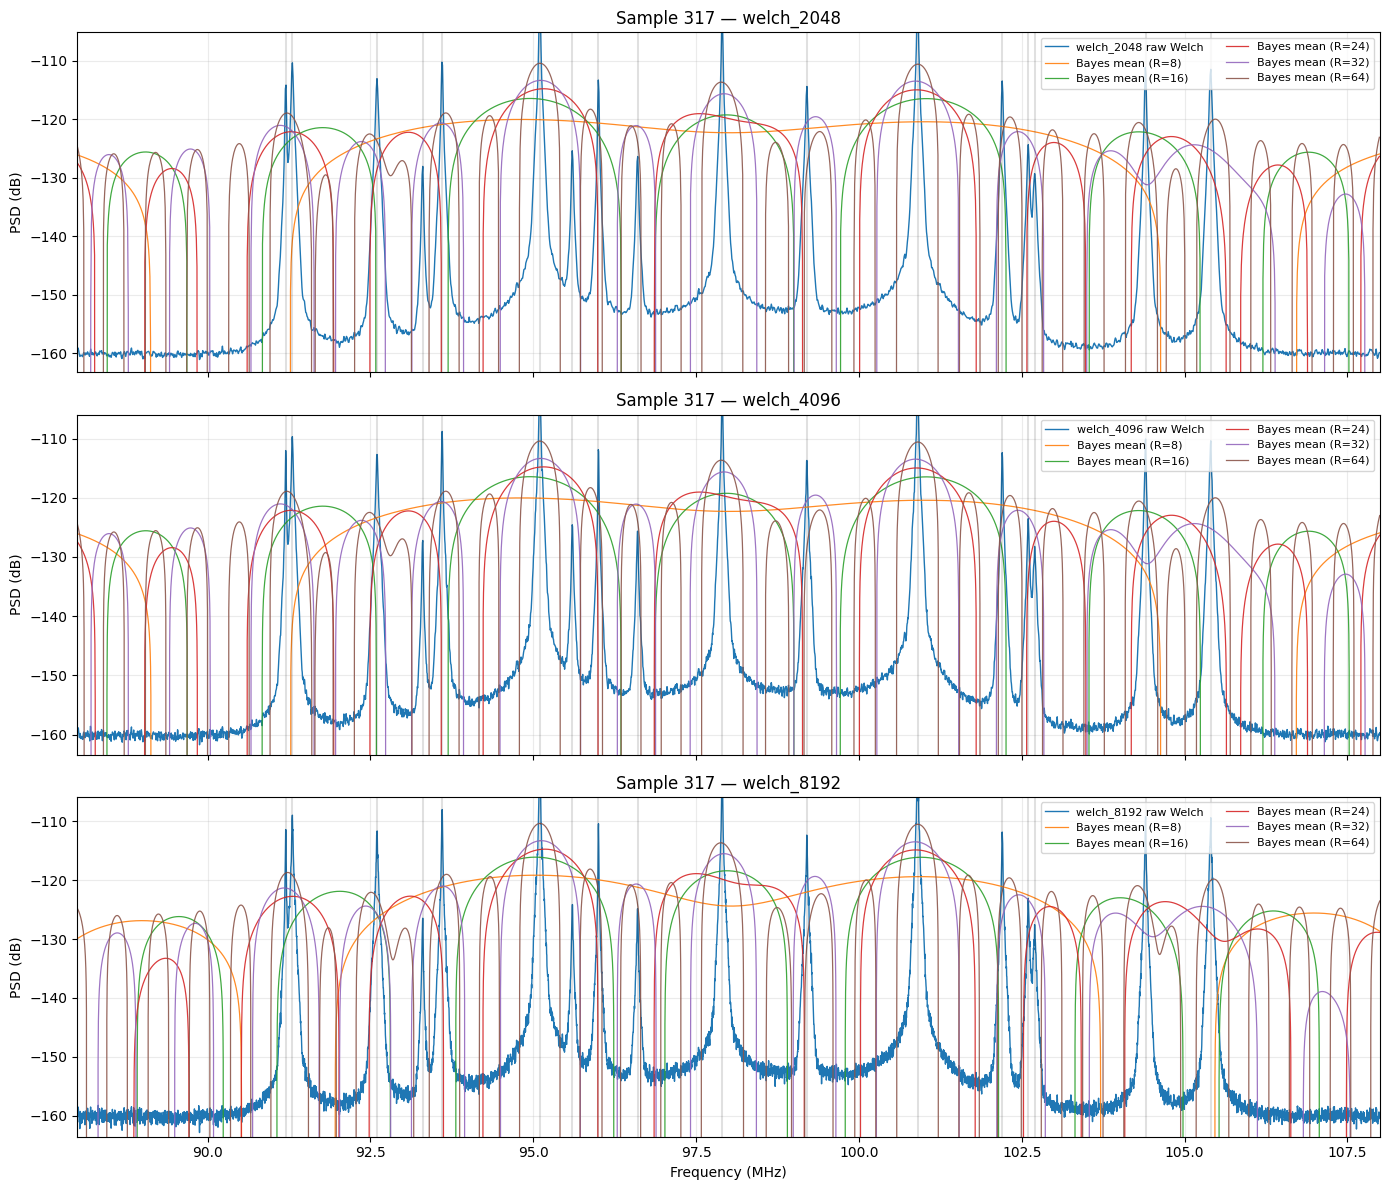

,sample,welch,R,precision,recall,f1,mae_center_hz,mae_bw_hz,n_true,n_pred
0,317,welch_2048,8,1.000000,0.176471,0.300000,7.761198e+06,5.066854e+06,17,3
1,317,welch_2048,16,1.000000,0.411765,0.583333,6.192522e+06,1.745418e+06,17,7
2,317,welch_2048,24,1.000000,0.647059,0.785714,7.119886e+06,1.016047e+06,17,11
3,317,welch_2048,32,1.000000,0.764706,0.866667,3.379087e+06,8.120765e+05,17,13
4,317,welch_2048,64,0.566667,1.000000,0.723404,2.372151e+06,3.009451e+05,17,30
5,317,welch_4096,8,1.000000,0.176471,0.300000,7.762826e+06,5.070109e+06,17,3
6,317,welch_4096,16,1.000000,0.411765,0.583333,6.191825e+06,1.750998e+06,17,7
7,317,welch_4096,24,1.000000,0.647059,0.785714,7.121218e+06,1.019154e+06,17,11
8,317,welch_4096,32,1.000000,0.764706,0.866667,3.378711e+06,8.169594e+05,17,13
9,317,welch_4096,64,0.566667,1.000000,0.723404,2.372438e+06,3.046791e+05,17,30


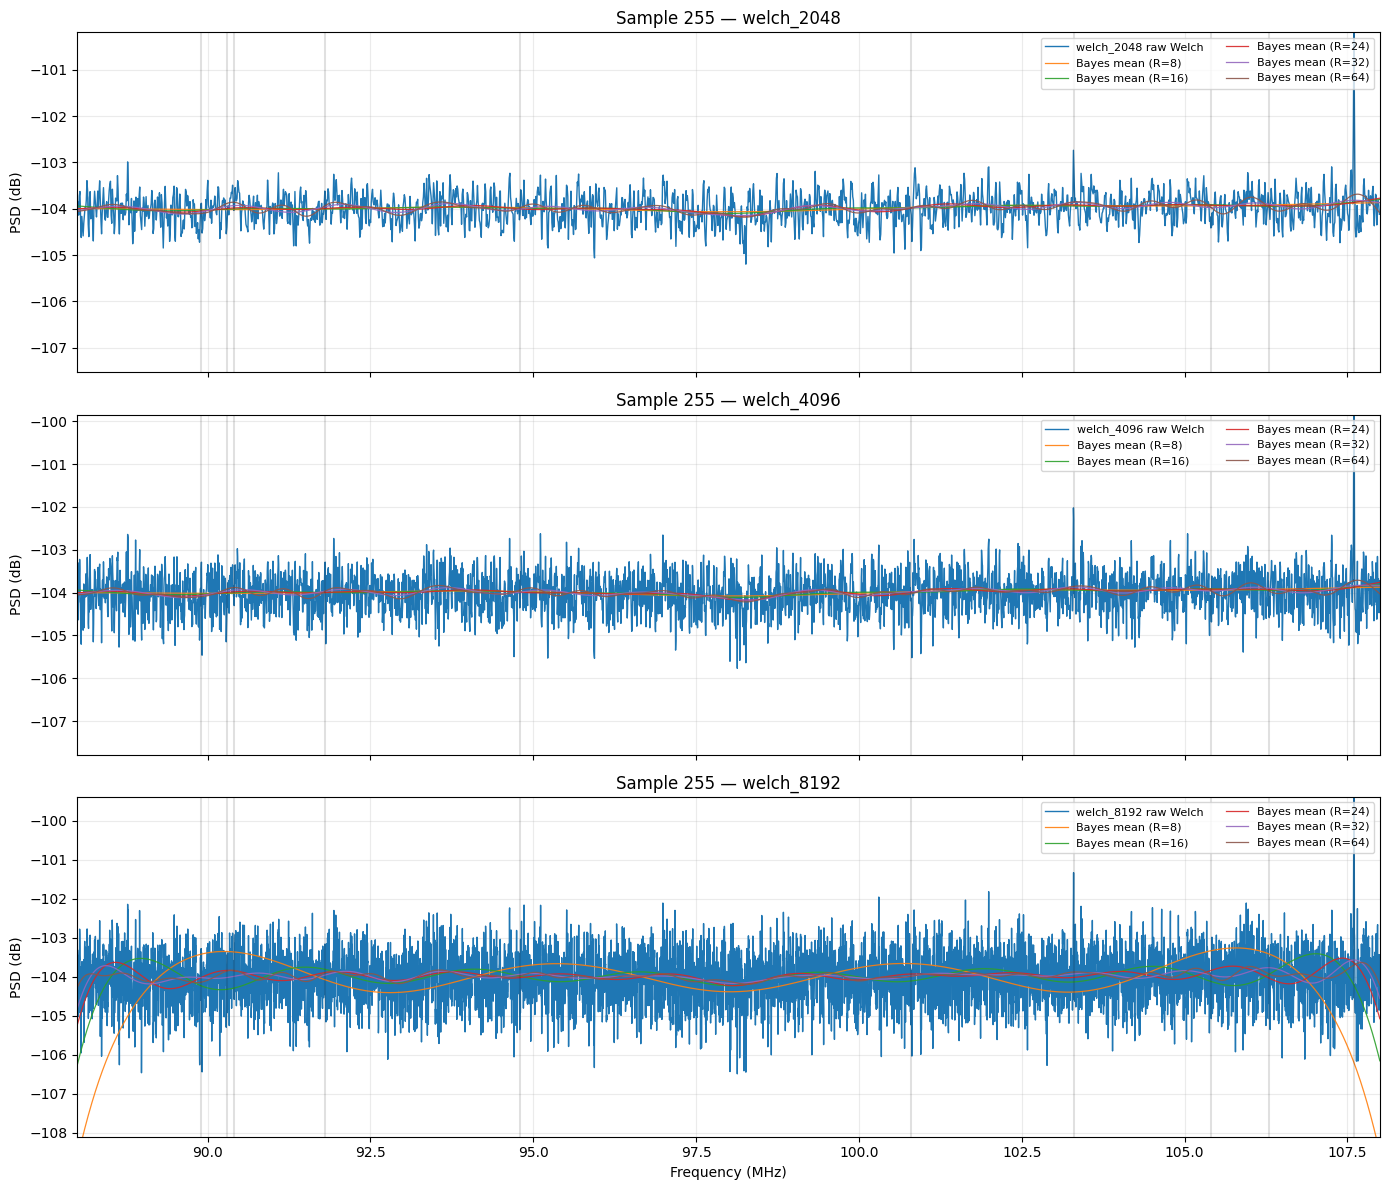

,sample,welch,R,precision,recall,f1,mae_center_hz,mae_bw_hz,n_true,n_pred
0,255,welch_2048,8,1.0,0.1,0.181818,1.319023e+07,1.984129e+07,10,1
1,255,welch_2048,16,1.0,0.1,0.181818,1.319023e+07,1.984129e+07,10,1
2,255,welch_2048,24,1.0,0.2,0.333333,9.167773e+06,9.463521e+06,10,2
3,255,welch_2048,32,1.0,0.2,0.333333,5.384766e+05,9.443216e+06,10,2
4,255,welch_2048,64,1.0,0.5,0.666667,1.391875e+06,3.592269e+06,10,5
5,255,welch_4096,8,1.0,0.1,0.181818,1.319512e+07,1.984617e+07,10,1
6,255,welch_4096,16,1.0,0.1,0.181818,1.319512e+07,1.984617e+07,10,1
7,255,welch_4096,24,1.0,0.2,0.333333,9.187305e+06,9.771138e+06,10,2
8,255,welch_4096,32,1.0,0.2,0.333333,6.434570e+05,9.821634e+06,10,2
9,255,welch_4096,64,1.0,0.2,0.333333,6.507812e+05,9.682474e+06,10,2


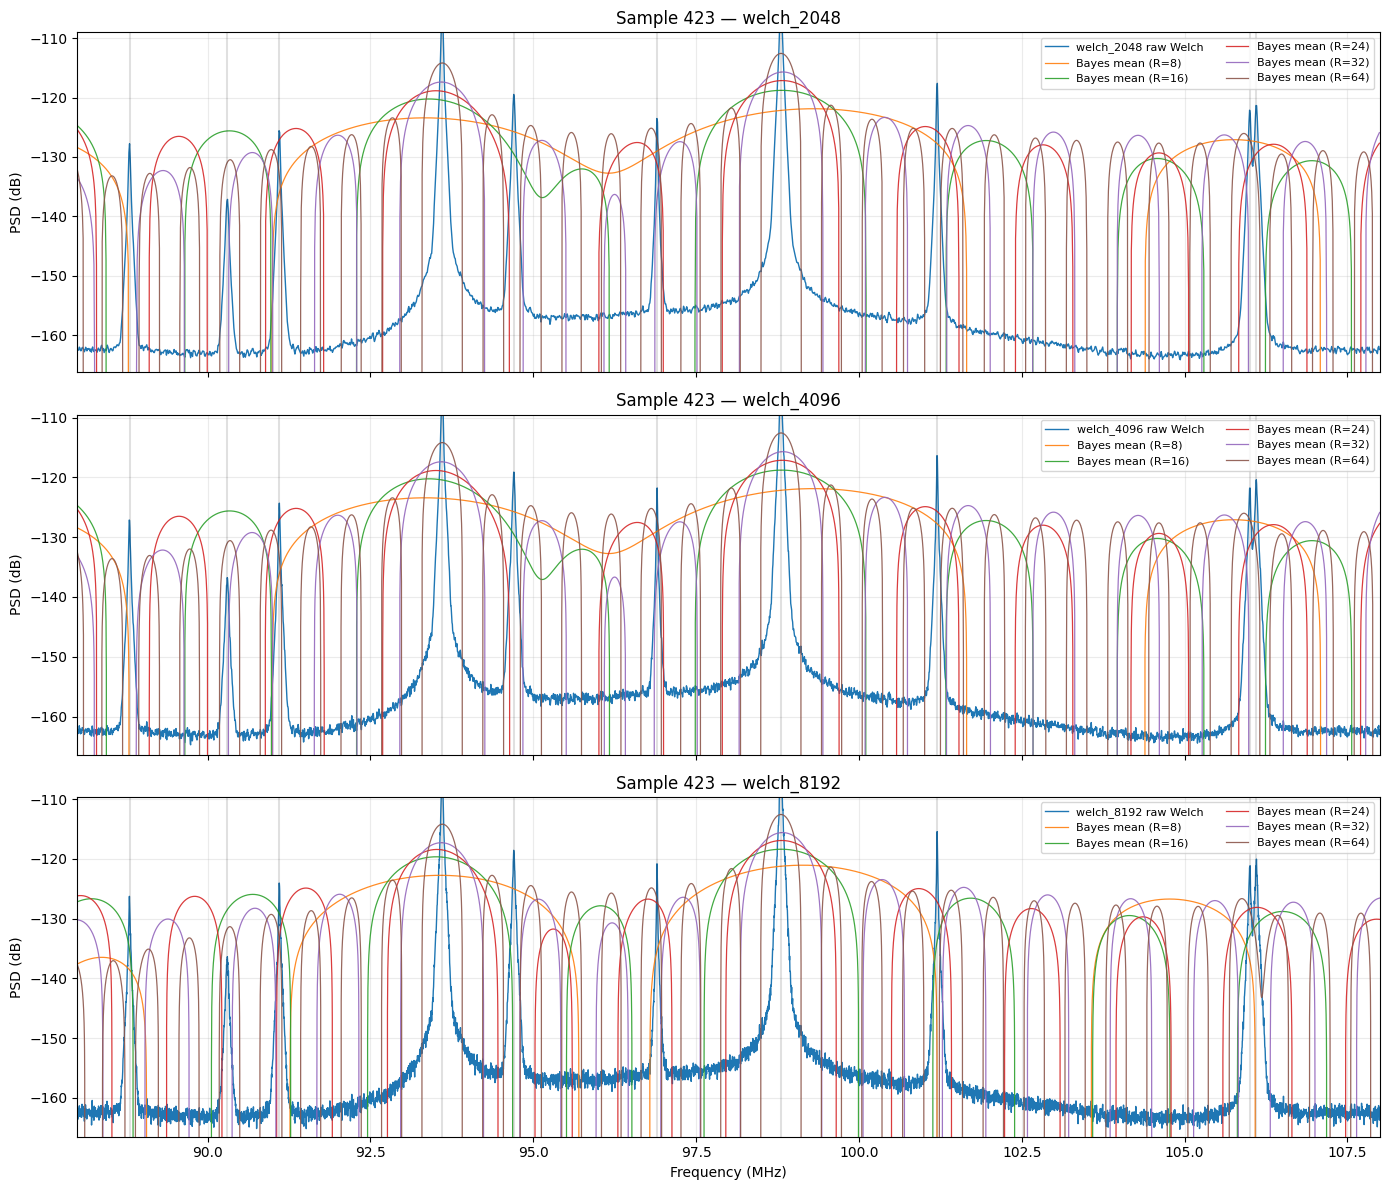

,sample,welch,R,precision,recall,f1,mae_center_hz,mae_bw_hz,n_true,n_pred
0,423,welch_2048,8,1.000000,0.3,0.461538,1.154844e+07,4.527689e+06,10,3
1,423,welch_2048,16,1.000000,0.7,0.823529,6.090904e+06,1.567651e+06,10,7
2,423,welch_2048,24,0.909091,1.0,0.952381,6.379297e+06,8.800179e+05,10,11
3,423,welch_2048,32,0.625000,1.0,0.769231,5.649805e+06,5.372444e+05,10,16
4,423,welch_2048,64,0.312500,1.0,0.476190,3.641016e+06,1.948373e+05,10,32
5,423,welch_4096,8,1.000000,0.3,0.461538,1.154844e+07,4.527689e+06,10,3
6,423,welch_4096,16,1.000000,0.7,0.823529,6.090904e+06,1.572534e+06,10,7
7,423,welch_4096,24,0.909091,1.0,0.952381,6.379297e+06,8.809944e+05,10,11
8,423,welch_4096,32,0.625000,1.0,0.769231,5.651758e+06,5.411507e+05,10,16
9,423,welch_4096,64,0.312500,1.0,0.476190,3.640527e+06,1.967904e+05,10,32


In [15]:
import json
import numpy as np
import matplotlib.pyplot as plt
import zarr
from pathlib import Path

def eval_sample_stations(preds, truths, max_freq_err_hz=200_000):
    from scipy.optimize import linear_sum_assignment

    if len(preds) == 0 or len(truths) == 0:
        return dict(
            precision=0.0,
            recall=0.0,
            f1=0.0,
            mae_center_hz=np.nan,
            mae_bw_hz=np.nan,
            n_true=len(truths),
            n_pred=len(preds),
        )

    cost = np.full((len(preds), len(truths)), 300_000, dtype=float)
    for i, p in enumerate(preds):
        for j, t in enumerate(truths):
            df = abs(p["f_peak_hz"] - t["f_center_hz"])
            if df <= max_freq_err_hz:
                cost[i, j] = df

    if not np.isfinite(cost).any():
        return dict(
            precision=0.0,
            recall=0.0,
            f1=0.0,
            mae_center_hz=np.nan,
            mae_bw_hz=np.nan,
            n_true=len(truths),
            n_pred=len(preds),
        )

    row_ind, col_ind = linear_sum_assignment(cost)

    matches = [(i, j) for i, j in zip(row_ind, col_ind) if np.isfinite(cost[i, j])]

    n_tp = len(matches)
    n_fp = len(preds) - n_tp
    n_fn = len(truths) - n_tp

    err_fc = []
    err_bw = []
    for i_p, i_t in matches:
        err_fc.append(abs(preds[i_p]["f_peak_hz"] - truths[i_t]["f_center_hz"]))
        err_bw.append(abs(preds[i_p]["bw_hz"] - truths[i_t]["bw_carson_hz"]))

    precision = n_tp / max(n_tp + n_fp, 1)
    recall = n_tp / max(n_tp + n_fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-12)

    return dict(
        precision=precision,
        recall=recall,
        f1=f1,
        mae_center_hz=np.mean(err_fc) if err_fc else np.nan,
        mae_bw_hz=np.mean(err_bw) if err_bw else np.nan,
        n_true=len(truths),
        n_pred=len(preds),
    )


# ----------------------------
# 0) EDIT THESE PATHS
# ----------------------------
DATASET_PATH = "fm_dataset_200k.zarr"
TUNING_RESULTS_JSON = "tuning_results.json"
MODELPACK_ROOT = Path("modelpacks_from_tuning")

R_TO_PLOT = [8, 16, 24, 32, 64]
K_SAMPLES = 3
SEED = 0
XLIM_MHZ = (88, 108)

# ----------------------------
# 1) Dataset helper (minimal)
# ----------------------------
def view_to_complex(v: np.ndarray, dtype=np.complex64) -> np.ndarray:
    v = np.asarray(v)
    if v.shape[-1] != 2:
        raise ValueError("Last dim must be 2 (real, imag).")
    if dtype == np.complex64:
        return v.astype(np.float32).reshape(v.shape[:-1] + (2,)).view(np.complex64).reshape(v.shape[:-1])
    raise ValueError("Only complex64 supported here.")

def load_jsonl(path: Path):
    return [json.loads(line) for line in path.read_text(encoding="utf-8").splitlines() if line.strip()]

root = zarr.open_group(DATASET_PATH, mode="r")
N = int(root["iq_reim"].shape[0])

emitters_json = load_jsonl(Path(DATASET_PATH) / "emitters.jsonl")
stations_json  = load_jsonl(Path(DATASET_PATH) / "stations.jsonl")
scenarios_json = load_jsonl(Path(DATASET_PATH) / "scenario.jsonl")

def get_sample(i: int):
    iq = view_to_complex(root["iq_reim"][i], dtype=np.complex64)
    return dict(
        iq=iq,
        fs=float(root["fs"][i]),
        fc=float(root["fc"][i]),
        stations=stations_json[i],
        emitters=emitters_json[i],
        scenario=scenarios_json[i],
    )

# ----------------------------
# 2) Welch configs present (from tuning json)
# ----------------------------
with open(TUNING_RESULTS_JSON, "r", encoding="utf-8") as f:
    tuning_results = json.load(f)

WELCH_NAMES = list(tuning_results.keys())
print("Welch configs found:", WELCH_NAMES)

# ----------------------------
# 3) Import your module classes
# ----------------------------
from spectrum_monitor import ModelPack, SpectrumMonitor

def load_modelpack(welch_name: str, R: int) -> ModelPack:
    # NEW naming pattern:
    # modelpacks_from_tuning/mp_{welch_name}_R{R}.npz
    mp_path = MODELPACK_ROOT / f"mp_{welch_name}_R{R}.npz"
    if not mp_path.exists():
        raise FileNotFoundError(f"Missing modelpack: {mp_path}")
    return ModelPack.load(mp_path)

# Cache modelpacks
MODEL_CACHE = {}
for wname in WELCH_NAMES:
    MODEL_CACHE[wname] = {}
    for R in R_TO_PLOT:
        try:
            MODEL_CACHE[wname][R] = load_modelpack(wname, R)
        except FileNotFoundError:
            pass

for wname in WELCH_NAMES:
    print(wname, "available R:", sorted(MODEL_CACHE[wname].keys()))

# ----------------------------
# 4) Plotting function per sample
# ----------------------------
def plot_one_sample_all_welch(sample, sample_idx: int):
    iq = sample["iq"]
    stations = sample["stations"]

    nrows = len(WELCH_NAMES)
    fig, axes = plt.subplots(nrows, 1, figsize=(14, 4*nrows), sharex=True)
    if nrows == 1:
        axes = [axes]

    rows_metrics = []

    for ax, wname in zip(axes, WELCH_NAMES):
        available_R = sorted(MODEL_CACHE[wname].keys())
        if len(available_R) == 0:
            ax.set_title(f"{wname}: no modelpacks found")
            ax.axis("off")
            continue

        mp0 = MODEL_CACHE[wname][available_R[0]]
        mon0 = SpectrumMonitor(mp0)

        # Raw Welch
        f_hz, psd_welch, _ = mon0.welch_psd(iq)
        f_mhz = f_hz / 1e6
        psd_db = 10*np.log10(np.maximum(psd_welch, 1e-30))

        ymin = np.percentile(psd_db, 5) - 3
        ymax = np.percentile(psd_db, 99.5) + 3

        ax.plot(f_mhz, psd_db, lw=1.0, label=f"{wname} raw Welch")

        for R in available_R:
            mp = MODEL_CACHE[wname][R]
            mon = SpectrumMonitor(mp)

            res = mon.infer_snapshot(
                iq,
                quiet_frac=float(
                    tuning_results[wname]["R_results"][str(R)]["best_params"].get("quiet_frac", 0.35)
                ),
                p_fa_bin=mp.p_fa_bin,
                pi0=mp.pi0,
                sigma_eps=mp.kernel_params.sigma_eps,
            )

            mu_db = 10*np.log10(np.maximum(res.mu_psd, 1e-30))
            ax.plot(f_mhz, mu_db, lw=0.9, alpha=0.9, label=f"Bayes mean (R={R})")

            m = eval_sample_stations(res.emitters, stations)
            rows_metrics.append(dict(
                sample=sample_idx,
                welch=wname,
                R=R,
                **m
            ))

        for st in stations:
            ax.axvline(st["f_center_hz"]/1e6, alpha=0.12, color="k")

        ax.set_title(f"Sample {sample_idx} — {wname}")
        ax.set_ylabel("PSD (dB)")
        ax.set_ylim(ymin, ymax)
        ax.grid(True, alpha=0.25)
        ax.set_xlim(*XLIM_MHZ)
        ax.legend(loc="upper right", ncols=2, fontsize=8)

    axes[-1].set_xlabel("Frequency (MHz)")
    plt.tight_layout()
    plt.show()

    # ---- metrics table ----
    df = pd.DataFrame(rows_metrics)
    display(
        df.sort_values(["welch", "R"])
          .reset_index(drop=True)
    )


# ----------------------------
# 5) Pick random samples and plot
# ----------------------------
rng = np.random.default_rng(SEED)
idxs = rng.choice(N, size=K_SAMPLES, replace=False)

print("Plotting sample indices:", idxs.tolist())
for i in idxs:
    s = get_sample(int(i))
    plot_one_sample_all_welch(s, int(i))


Welch configs found: ['welch_2048', 'welch_4096', 'welch_8192']
welch_2048 available R: [32]
welch_4096 available R: [32]
welch_8192 available R: [32]
Plotting sample indices: [317, 255, 423]


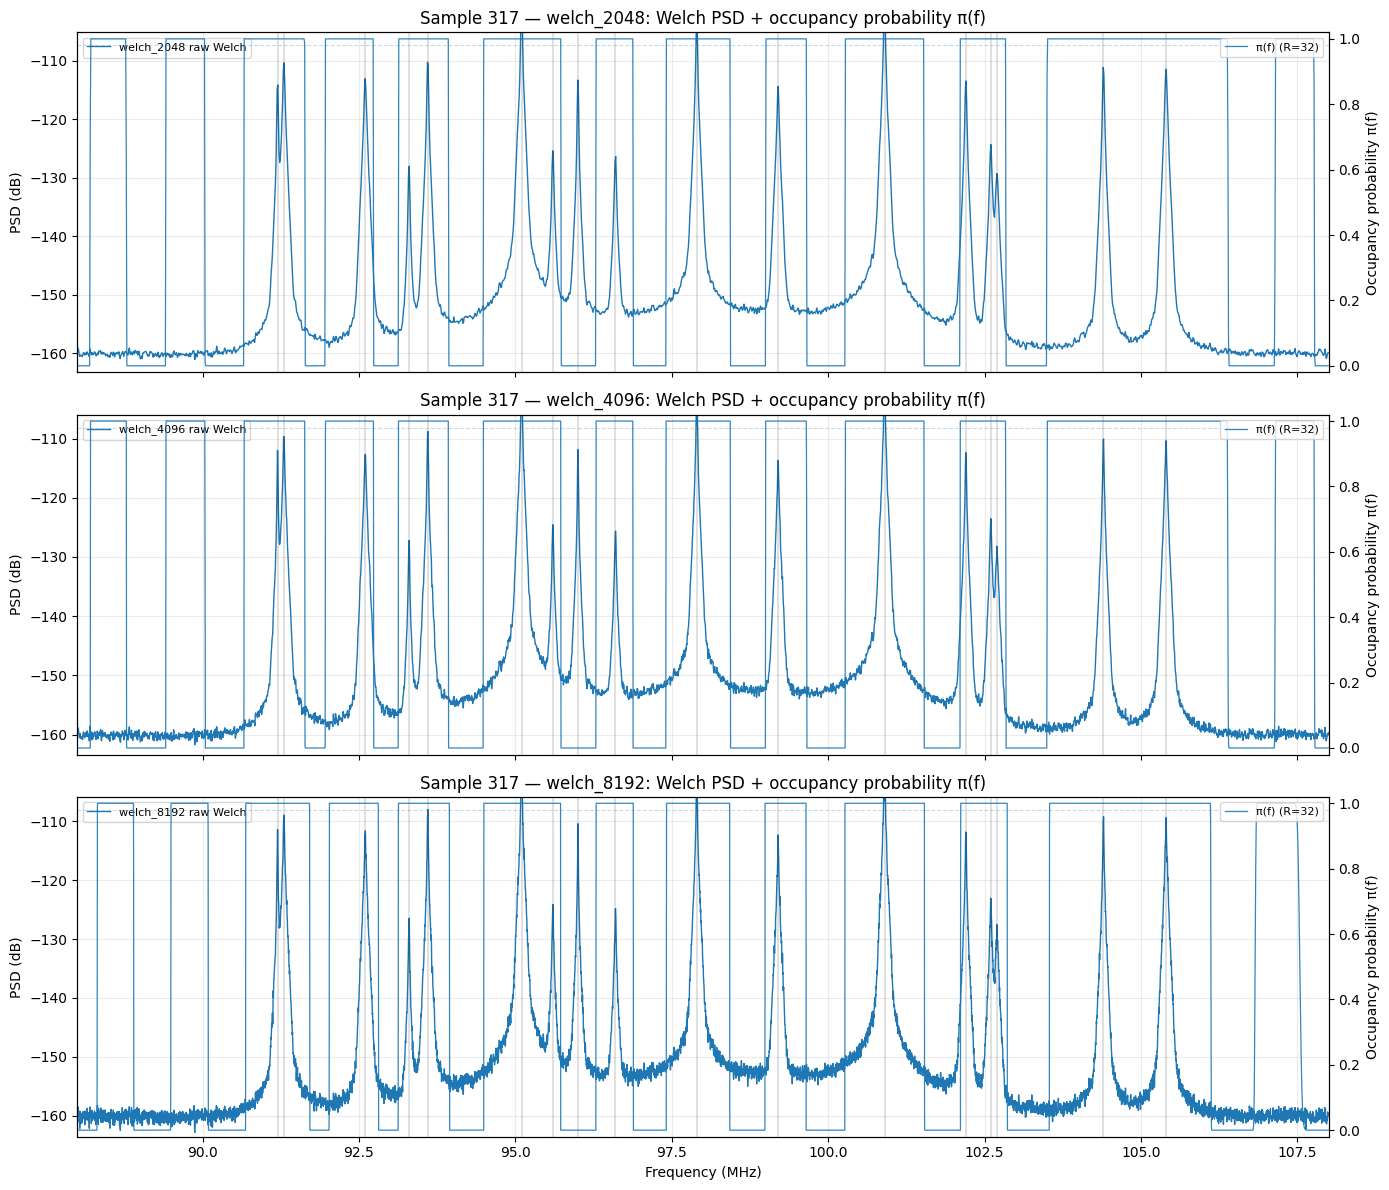

,sample,welch,R,precision,recall,f1,mae_center_hz,mae_bw_hz,n_true,n_pred
0,317,welch_2048,32,0.615385,0.470588,0.533333,62353.515625,750528.135268,17,13
1,317,welch_4096,32,0.615385,0.470588,0.533333,61743.164062,754190.244643,17,13
2,317,welch_8192,32,0.769231,0.588235,0.666667,71044.921875,910446.154208,17,13


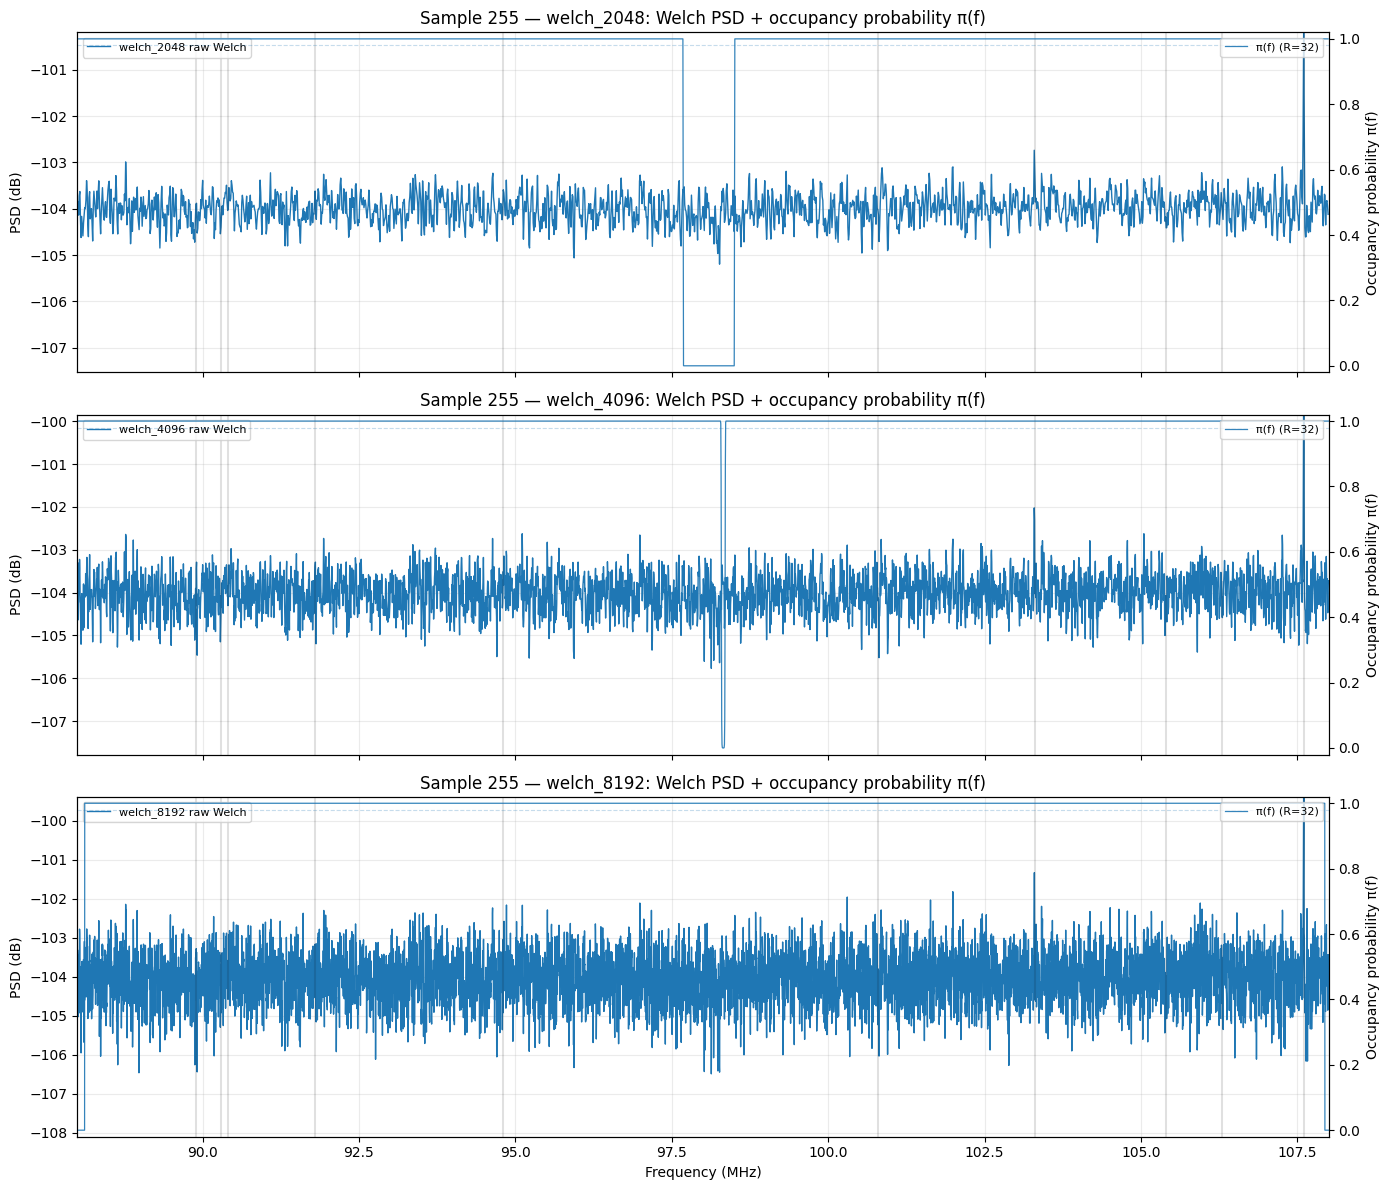

,sample,welch,R,precision,recall,f1,mae_center_hz,mae_bw_hz,n_true,n_pred
0,255,welch_2048,32,0.5,0.1,0.166667,9375.00000,9.357642e+06,10,2
1,255,welch_4096,32,0.5,0.1,0.166667,190039.06250,9.509009e+06,10,2
2,255,welch_8192,32,1.0,0.1,0.181818,2050.78125,1.969456e+07,10,1


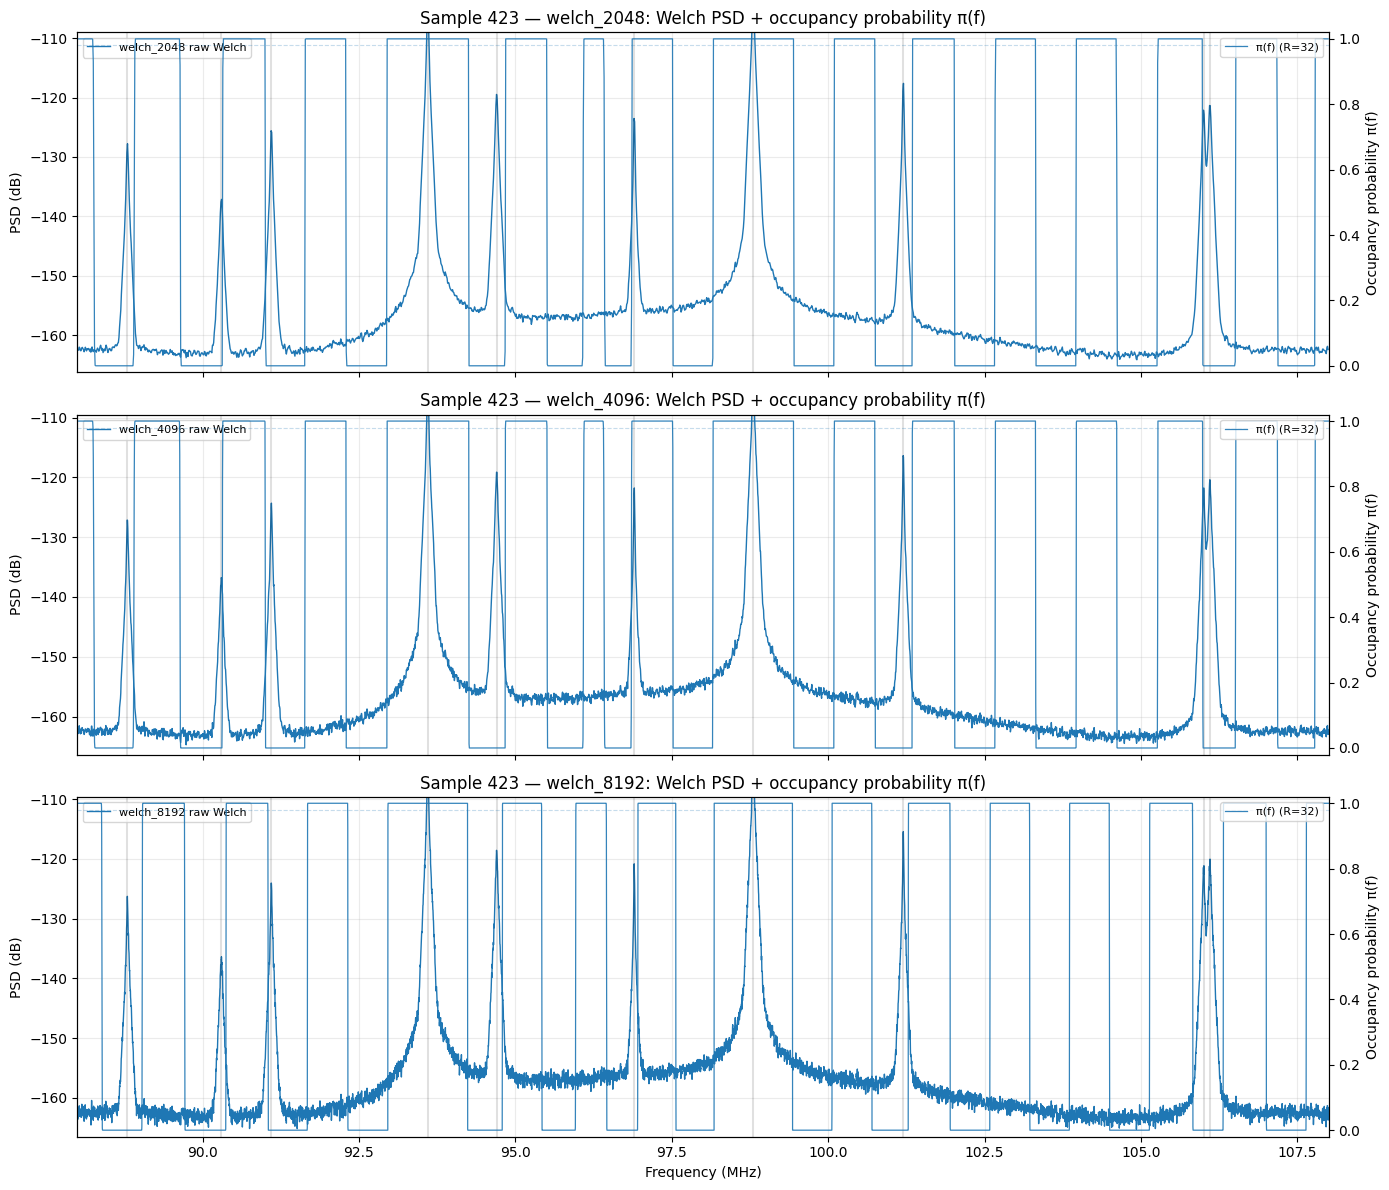

,sample,welch,R,precision,recall,f1,mae_center_hz,mae_bw_hz,n_true,n_pred
0,423,welch_2048,32,0.125,0.2,0.153846,22070.31250,1.121701e+06,10,16
1,423,welch_4096,32,0.125,0.2,0.153846,24511.71875,1.126584e+06,10,16
2,423,welch_8192,32,0.125,0.2,0.153846,19628.90625,1.093625e+06,10,16


In [20]:
import json
import numpy as np
import matplotlib.pyplot as plt
import zarr
from pathlib import Path
import pandas as pd

def eval_sample_stations(preds, truths, max_freq_err_hz=200_000):
    from scipy.optimize import linear_sum_assignment

    if len(preds) == 0 or len(truths) == 0:
        return dict(
            precision=0.0,
            recall=0.0,
            f1=0.0,
            mae_center_hz=np.nan,
            mae_bw_hz=np.nan,
            n_true=len(truths),
            n_pred=len(preds),
        )

    # finite penalty cost so assignment is always feasible
    cost = np.full((len(preds), len(truths)), 300_000.0, dtype=float)
    for i, p in enumerate(preds):
        for j, t in enumerate(truths):
            df = abs(p["f_peak_hz"] - t["f_center_hz"])
            if df <= max_freq_err_hz:
                cost[i, j] = df

    row_ind, col_ind = linear_sum_assignment(cost)

    matches = [(i, j) for i, j in zip(row_ind, col_ind) if cost[i, j] <= max_freq_err_hz]

    n_tp = len(matches)
    n_fp = len(preds) - n_tp
    n_fn = len(truths) - n_tp

    err_fc = []
    err_bw = []
    for i_p, i_t in matches:
        err_fc.append(abs(preds[i_p]["f_peak_hz"] - truths[i_t]["f_center_hz"]))
        err_bw.append(abs(preds[i_p]["bw_hz"] - truths[i_t]["bw_carson_hz"]))

    precision = n_tp / max(n_tp + n_fp, 1)
    recall = n_tp / max(n_tp + n_fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-12)

    return dict(
        precision=float(precision),
        recall=float(recall),
        f1=float(f1),
        mae_center_hz=float(np.mean(err_fc)) if err_fc else np.nan,
        mae_bw_hz=float(np.mean(err_bw)) if err_bw else np.nan,
        n_true=len(truths),
        n_pred=len(preds),
    )


# ----------------------------
# 0) EDIT THESE PATHS
# ----------------------------
DATASET_PATH = "fm_dataset_200k.zarr"
TUNING_RESULTS_JSON = "tuning_results.json"
MODELPACK_ROOT = Path("modelpacks_from_tuning")

R_TO_PLOT = [32]
K_SAMPLES = 3
SEED = 0
XLIM_MHZ = (88, 108)

# ----------------------------
# 1) Dataset helper (minimal)
# ----------------------------
def view_to_complex(v: np.ndarray, dtype=np.complex64) -> np.ndarray:
    v = np.asarray(v)
    if v.shape[-1] != 2:
        raise ValueError("Last dim must be 2 (real, imag).")
    if dtype == np.complex64:
        return v.astype(np.float32).reshape(v.shape[:-1] + (2,)).view(np.complex64).reshape(v.shape[:-1])
    raise ValueError("Only complex64 supported here.")

def load_jsonl(path: Path):
    return [json.loads(line) for line in path.read_text(encoding="utf-8").splitlines() if line.strip()]

root = zarr.open_group(DATASET_PATH, mode="r")
N = int(root["iq_reim"].shape[0])

emitters_json = load_jsonl(Path(DATASET_PATH) / "emitters.jsonl")
stations_json  = load_jsonl(Path(DATASET_PATH) / "stations.jsonl")
scenarios_json = load_jsonl(Path(DATASET_PATH) / "scenario.jsonl")

def get_sample(i: int):
    iq = view_to_complex(root["iq_reim"][i], dtype=np.complex64)
    return dict(
        iq=iq,
        fs=float(root["fs"][i]),
        fc=float(root["fc"][i]),
        stations=stations_json[i],
        emitters=emitters_json[i],
        scenario=scenarios_json[i],
    )

# ----------------------------
# 2) Welch configs present (from tuning json)
# ----------------------------
with open(TUNING_RESULTS_JSON, "r", encoding="utf-8") as f:
    tuning_results = json.load(f)

WELCH_NAMES = list(tuning_results.keys())
print("Welch configs found:", WELCH_NAMES)

# ----------------------------
# 3) Import your module classes
# ----------------------------
from spectrum_monitor import ModelPack, SpectrumMonitor

def load_modelpack(welch_name: str, R: int) -> ModelPack:
    mp_path = MODELPACK_ROOT / f"mp_{welch_name}_R{R}.npz"
    if not mp_path.exists():
        raise FileNotFoundError(f"Missing modelpack: {mp_path}")
    return ModelPack.load(mp_path)

MODEL_CACHE = {}
for wname in WELCH_NAMES:
    MODEL_CACHE[wname] = {}
    for R in R_TO_PLOT:
        try:
            MODEL_CACHE[wname][R] = load_modelpack(wname, R)
        except FileNotFoundError:
            pass

for wname in WELCH_NAMES:
    print(wname, "available R:", sorted(MODEL_CACHE[wname].keys()))

# ----------------------------
# 4) Plotting function per sample
# ----------------------------
def plot_one_sample_all_welch_pi(sample, sample_idx: int):
    iq = sample["iq"]
    stations = sample["stations"]

    nrows = len(WELCH_NAMES)
    fig, axes = plt.subplots(nrows, 1, figsize=(14, 4*nrows), sharex=True)
    if nrows == 1:
        axes = [axes]

    rows_metrics = []

    for ax, wname in zip(axes, WELCH_NAMES):
        available_R = sorted(MODEL_CACHE[wname].keys())
        if len(available_R) == 0:
            ax.set_title(f"{wname}: no modelpacks found")
            ax.axis("off")
            continue

        # left axis: Welch PSD
        mp0 = MODEL_CACHE[wname][available_R[0]]
        mon0 = SpectrumMonitor(mp0)
        f_hz, psd_welch, _ = mon0.welch_psd(iq)
        f_mhz = f_hz / 1e6
        psd_db = 10*np.log10(np.maximum(psd_welch, 1e-30))

        ymin = np.percentile(psd_db, 5) - 3
        ymax = np.percentile(psd_db, 99.5) + 3

        ax.plot(f_mhz, psd_db, lw=1.0, label=f"{wname} raw Welch")
        ax.set_ylabel("PSD (dB)")
        ax.set_ylim(ymin, ymax)
        ax.grid(True, alpha=0.25)
        ax.set_xlim(*XLIM_MHZ)

        # right axis: occupancy probability
        ax2 = ax.twinx()
        ax2.set_ylabel("Occupancy probability π(f)")
        ax2.set_ylim(-0.02, 1.02)

        for R in available_R:
            mp = MODEL_CACHE[wname][R]
            mon = SpectrumMonitor(mp)

            best_params = tuning_results[wname]["R_results"][str(R)]["best_params"]
            quiet_frac = float(best_params.get("quiet_frac", 0.35))
            p_fa_bin = float(best_params.get("p_fa_bin", mp.p_fa_bin))
            pi0 = float(best_params.get("pi0", mp.pi0))
            sigma_eps = float(best_params.get("sigma_eps", mp.kernel_params.sigma_eps))

            res = mon.infer_snapshot(
                iq,
                quiet_frac=quiet_frac,
                p_fa_bin=p_fa_bin,
                pi0=pi0,
                sigma_eps=sigma_eps,
            )

            # plot occupancy probability
            ax2.plot(f_mhz, res.pi_bin, lw=0.9, alpha=0.9, label=f"π(f) (R={R})")

            # optional: show threshold once per axis (same pi0 for all R? not necessarily)
            # Here we draw per-R threshold faintly:
            ax2.axhline(pi0, ls="--", lw=0.8, alpha=0.25)

            # metrics still computed from emitters derived from occ mask
            m = eval_sample_stations(res.emitters, stations)
            rows_metrics.append(dict(sample=sample_idx, welch=wname, R=R, **m))

        # mark true station centers
        for st in stations:
            ax.axvline(st["f_center_hz"]/1e6, alpha=0.12, color="k")

        ax.set_title(f"Sample {sample_idx} — {wname}: Welch PSD + occupancy probability π(f)")

        # legends: one per axis
        ax.legend(loc="upper left", fontsize=8)
        ax2.legend(loc="upper right", ncols=2, fontsize=8)

    axes[-1].set_xlabel("Frequency (MHz)")
    plt.tight_layout()
    plt.show()

    # metrics table
    df = pd.DataFrame(rows_metrics)
    display(df.sort_values(["welch", "R"]).reset_index(drop=True))


# ----------------------------
# 5) Pick random samples and plot
# ----------------------------
rng = np.random.default_rng(SEED)
idxs = rng.choice(N, size=K_SAMPLES, replace=False)

print("Plotting sample indices:", idxs.tolist())
for i in idxs:
    s = get_sample(int(i))
    plot_one_sample_all_welch_pi(s, int(i))
